# Small Business Pulse Survey Analysis

In this notebook, I analyzed the impact of `Covid-19` on small business using data from the Small Business Pulse Survey by US Census. 

The target population is all nonfarm, single-location employer businesses with between 1-499 employees and receipts of $1,000 or more in the 50 states, District of Columbia, and Puerto Rico. The Census Bureau invites over 90,000 businesses to respond each week, reaching nearly one million small businesses across a 9-week rotation.

Topics including: 
- overall impact 
- revenue
- operation
- employee
- financial issues

Data reference: [Small Business Pulse Survey](https://portal.census.gov/pulse/data/#downloads).

In [1]:
#install packages
!pip install geopandas
!pip install descartes

  Using cached geopandas-0.8.1-py2.py3-none-any.whl (962 kB)
     |████████████████████████████████| 1.0 MB 3.3 MB/s eta 0:00:01
  Using cached pyproj-2.6.1.post1-cp38-cp38-manylinux2010_x86_64.whl (10.9 MB)
  Using cached Fiona-1.8.13.post1-cp38-cp38-manylinux1_x86_64.whl (14.7 MB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached cligj-0.5.0-py3-none-any.whl (5.7 kB)
  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
sns.set_palette('Blues') 

In [3]:
#4/26-5/2
#22,449 respondent
#Survey collection period includes the beginning and end dates of the period during which responses were collected. 
#Note that businesses were questioned regarding the experience of their business 
#in the last week and since the start of the COVID-19 pandemic.
sbusiness = pd.read_csv('national_state_26Apr20_2May20.csv')
sbusiness

,ST,INSTRUMENT_ID,ANSWER_ID,ESTIMATE_PERCENTAGE,SE
0,AK,1,1,0.454,6.66
1,AK,1,2,0.440,5.79
2,AK,2,2,0.655,3.81
3,AK,2,3,0.255,3.98
4,AK,3,1,0.319,4.04
...,...,...,...,...,...
2800,-,15,2,0.241,0.51
2801,-,15,3,0.277,0.48
2802,-,15,4,0.314,0.36
2803,-,15,5,0.062,0.30


In [4]:
#upload week2-week9 data
sb_2 = pd.read_csv('national_state_3May20_9May20.csv')
sb_3 = pd.read_csv('national_state_10May20_16May20.csv')
sb_4 = pd.read_csv('national_state_17May20_23May20.csv')
sb_5 = pd.read_csv('national_state_24May20_30May20.csv')
sb_6 = pd.read_csv('national_state_31May20_06Jun20.csv')
sb_7 = pd.read_csv('national_state_07Jun20_13Jun20.csv')
sb_8 = pd.read_csv('national_state_14Jun20_20Jun20.csv')
sb_9 = pd.read_csv('national_state_21Jun20_27Jun20.csv')

In [5]:
policy = pd.read_csv('COVID-19 US state policy database 6_18_2020.csv')
policy.head()

,STATE,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,CLNURSHM,STAYHOME,END_STHM,CLBSNS,END_BSNS,...,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18
0,State,AL,State of emergency,Date closed K-12 schools,Closed day cares,Date banned visitors to nursing homes,Stay at home/ shelter in place,End/relax stay at home/shelter in place,Closed non-essential businesses,Began to reopen businesses,...,Paid sick leave,Medicaid Expansion,Population density per square miles,Population 2018,Square Miles,Number Homeless (2019),Percent Unemployed (2018),Percent living under the federal poverty line ...,Percent at risk for serious illness due to COVID,All-cause deaths 2018
1,category,postcode,emergency,school_closure,day_care_closure,nursing_home_visit_ban,shelter,shelter,business_closure,business_closure,...,paid_sick_leave,medicaid_expansion,population_density,population,area,homeless,unemployment,poverty,at_risk,all_cause_deaths
2,type,note,start,start,start,start,start,end,start,end,...,attribute,attribute,quantity,quantity,quantity,quantity,quantity,quantity,quantity,quantity
3,unit,text,date,date,date,date,date,date,date,date,...,flag,flag,people/sq mi,people,sq mi,people,percent,percent,percent,people/year
4,Alabama,AK,2020/3/13,2020/3/19,2020/3/20,2020/3/19,2020/4/4,2020/4/30,2020/3/28,2020/4/30,...,0,0,93.24,4887871,52420,"3,261",5.6,16.8,43.1,"54,352"


## Part 1: Data Selection and Cleaning
In this part, I renamed the columns and seperated the dataset into two sub-datasets, overall estimates (rows with '-' as input for state) and state specifics.

In [6]:
sbusiness = sbusiness.rename(columns={'ST': 'State', 'INSTRUMENT_ID':'Question ID', 'ANSWER_ID':'Answer ID',
                          'ESTIMATE_PERCENTAGE':'Estimate Percentage', 'SE':'Standard Error'})
sbusiness.head()

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,1,1,0.454,6.66
1,AK,1,2,0.440,5.79
2,AK,2,2,0.655,3.81
3,AK,2,3,0.255,3.98
4,AK,3,1,0.319,4.04


In [7]:
complete_df = sbusiness.copy()
complete_df.head()

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,1,1,0.454,6.66
1,AK,1,2,0.440,5.79
2,AK,2,2,0.655,3.81
3,AK,2,3,0.255,3.98
4,AK,3,1,0.319,4.04


In [8]:
sbusiness.shape

(2805, 5)

In [9]:
#The target population is all nonfarm, single-location employer businesses with between 1-499 employees and 
#receipts of $1,000 or more in the 50 states, District of Columbia, and Puerto Rico. 
#one extra '-' input for overall estimate
sbusiness['State'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', '-'], dtype=object)

In [10]:
overall_row = sbusiness.loc[sbusiness['State']=='-'].index.to_list()
len(overall_row)

64

In [11]:
overall = sbusiness.iloc[overall_row,:].reset_index(drop=True)
overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,1,1,0.514,1.01
1,-,1,2,0.385,0.79
2,-,1,3,0.076,0.38
3,-,1,4,0.017,0.08
4,-,1,5,0.008,0.06
...,...,...,...,...,...
59,-,15,2,0.241,0.51
60,-,15,3,0.277,0.48
61,-,15,4,0.314,0.36
62,-,15,5,0.062,0.30


In [12]:
sbusiness = sbusiness.drop(overall_row)
sbusiness.shape

(2741, 5)

In [13]:
sbusiness.loc[sbusiness['State']=='-']

,State,Question ID,Answer ID,Estimate Percentage,Standard Error


In [14]:
null_columns = sbusiness.columns[sbusiness.isnull().any()]
sbusiness[null_columns].isnull().sum()

Series([], dtype: float64)

clean the rest datasets (week2-week9) using the same method as above

In [15]:
def clean(table):
    table = table.rename(columns={'ST': 'State', 'INSTRUMENT_ID':'Question ID', 'ANSWER_ID':'Answer ID',
                          'ESTIMATE_PERCENTAGE':'Estimate Percentage', 'SE':'Standard Error'})
    overall_row = table.loc[table['State']=='-'].index.to_list()
    overall = table.iloc[overall_row,:].reset_index(drop=True)
    table = table.drop(overall_row).reset_index(drop=True)
    return table, overall

In [16]:
sb_2, overall_2 = clean(sb_2)
sb_3, overall_3 = clean(sb_3)
sb_4, overall_4 = clean(sb_4)
sb_5, overall_5 = clean(sb_5)
sb_6, overall_6 = clean(sb_6)
sb_7, overall_7 = clean(sb_7)
sb_8, overall_8 = clean(sb_8)
sb_9, overall_9 = clean(sb_9)

clean the policy table

In [17]:
policy = policy.drop([0, 1, 2, 3]).reset_index(drop=True)
policy.head()

,STATE,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,CLNURSHM,STAYHOME,END_STHM,CLBSNS,END_BSNS,...,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18
0,Alabama,AK,2020/3/13,2020/3/19,2020/3/20,2020/3/19,2020/4/4,2020/4/30,2020/3/28,2020/4/30,...,0,0,93.24,4887871,52420,"3,261",5.6,16.8,43.1,"54,352"
1,Alaska,AZ,2020/3/11,2020/3/16,0,0,2020/3/28,2020/4/24,2020/3/28,2020/4/24,...,0,1,1.11,737438,665384,"1,907",6.8,10.9,32.8,"4,453"
2,Arizona,AR,2020/3/11,2020/3/16,0,0,2020/3/31,2020/5/16,2020/3/30,2020/5/8,...,1,1,62.91,7171646,113990,"10,007",5.4,14,39.1,"59,282"
3,Arkansas,CA,2020/3/11,2020/3/17,0,2020/3/13,0,0,0,2020/5/4,...,0,1,56.67,3013825,53179,"2,717",4.5,17.2,43.5,"32,336"
4,California,CO,2020/3/4,0,0,0,2020/3/19,0,2020/3/19,2020/5/8,...,1,1,241.65,39557045,163695,"151,278",5.5,12.8,33.3,"268,818"


In [18]:
policy.shape

(1000, 71)

In [19]:
nullrows = policy.loc[policy['STATE'].isnull()].index

In [20]:
policy = policy.drop(nullrows).reset_index(drop=True)
policy.head()

,STATE,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,CLNURSHM,STAYHOME,END_STHM,CLBSNS,END_BSNS,...,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18
0,Alabama,AK,2020/3/13,2020/3/19,2020/3/20,2020/3/19,2020/4/4,2020/4/30,2020/3/28,2020/4/30,...,0,0,93.24,4887871,52420,"3,261",5.6,16.8,43.1,"54,352"
1,Alaska,AZ,2020/3/11,2020/3/16,0,0,2020/3/28,2020/4/24,2020/3/28,2020/4/24,...,0,1,1.11,737438,665384,"1,907",6.8,10.9,32.8,"4,453"
2,Arizona,AR,2020/3/11,2020/3/16,0,0,2020/3/31,2020/5/16,2020/3/30,2020/5/8,...,1,1,62.91,7171646,113990,"10,007",5.4,14,39.1,"59,282"
3,Arkansas,CA,2020/3/11,2020/3/17,0,2020/3/13,0,0,0,2020/5/4,...,0,1,56.67,3013825,53179,"2,717",4.5,17.2,43.5,"32,336"
4,California,CO,2020/3/4,0,0,0,2020/3/19,0,2020/3/19,2020/5/8,...,1,1,241.65,39557045,163695,"151,278",5.5,12.8,33.3,"268,818"


## Part 2: EDA
In this part, I will go explore responses of each question in the Small Business Pulse Survey to see how small businesses have been affected by COVID-19. 

### Overall impact
#### Q1) Overall, how has this business been affected by the COVID-19 pandemic?

**a)** First, we are going to see in general, how American Small Business has been influenced by the pandemic.

In [21]:
#return inputs for question 1
def return_input(table, question):
    q = table.loc[table['Question ID']==question].reset_index(drop=True)
    return q

In [22]:
#use the overall dataframe
q1_overall = return_input(overall, 1)#week1
q1_overall_2 = return_input(overall_2, 1)#week2
q1_overall_3 = return_input(overall_3, 1)
q1_overall_4 = return_input(overall_4, 1)
q1_overall_5 = return_input(overall_5, 1)
q1_overall_6 = return_input(overall_6, 1)
q1_overall_7 = return_input(overall_7, 1)
q1_overall_8 = return_input(overall_8, 1)
q1_overall_9 = return_input(overall_9, 1)

In [23]:
q1_overall_2

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,1,1,0.485,0.33
1,-,1,2,0.395,0.36
2,-,1,3,0.090,0.14
3,-,1,4,0.019,0.12
4,-,1,5,0.011,0.09


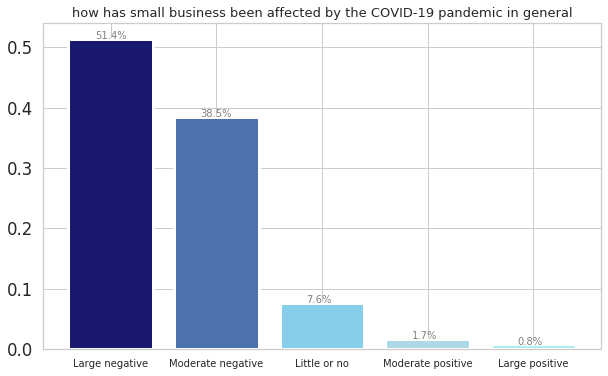

In [24]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.bar(q1_overall.index,'Estimate Percentage', linewidth=3, data=q1_overall,
       color=['midnightblue','b','skyblue','lightblue','paleturquoise']);
ax.set_title('how has small business been affected by the COVID-19 pandemic in general',size=13)
positions = (0,1,2,3,4)
labels = ("Large negative", "Moderate negative", "Little or no", "Moderate positive", "Large positive")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

##### Weekly change (4/26-6/27)

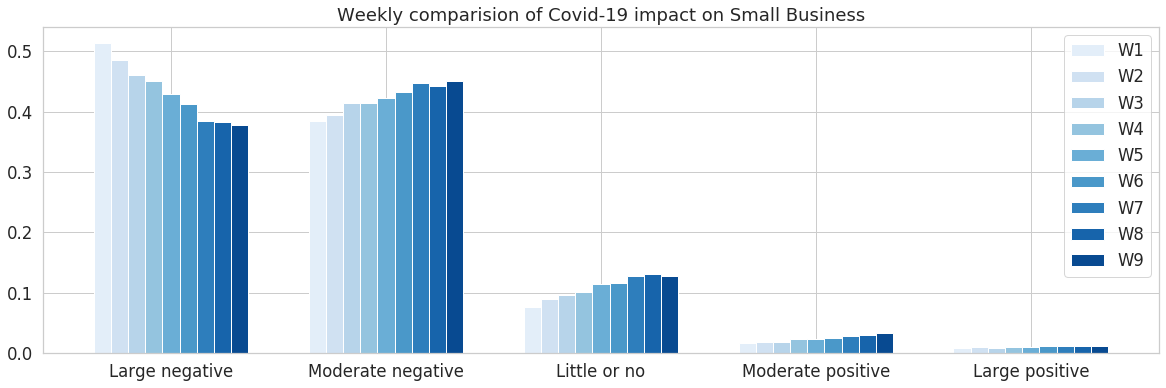

In [25]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(20,6))
plt.bar(q1_overall.index, q1_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q1_overall.index+width, q1_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q1_overall.index+width*2, q1_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q1_overall.index+width*3, q1_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q1_overall.index+width*4, q1_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q1_overall.index+width*5, q1_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q1_overall.index+width*6, q1_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q1_overall.index+width*7, q1_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q1_overall.index+width*8, q1_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Covid-19 impact on Small Business')
positions = (0+width*4,1+width*4,2+width*4,3+width*4,4+width*4)
labels = ("Large negative", "Moderate negative", "Little or no", "Moderate positive", "Large positive")
plt.xticks(positions, labels);
plt.legend(loc='best')
plt.show()

In [26]:
#function that returns the corresponsing value from each dataset for different impact level
def get_val(table_list,level):
    array = []
    for i in table_list:
        array.append(i['Estimate Percentage'].to_list()[level])
    return np.array(array)

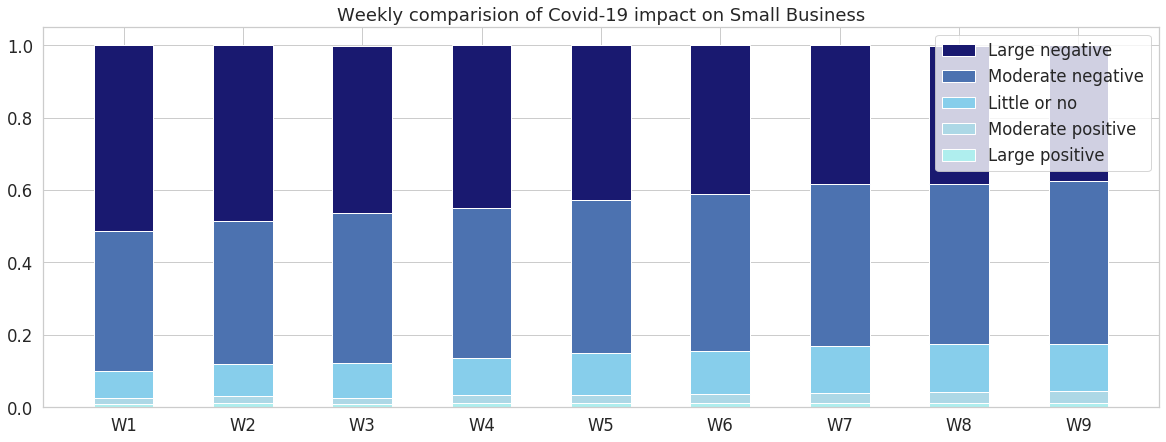

In [27]:
#stacked bar chart
plt.figure(figsize=(20,7))
labels = ["W1", "W2", "W3", "W4", "W5", "W6", "W7", "W8", "W9"]
large_n = get_val([q1_overall,q1_overall_2,q1_overall_3,q1_overall_4,q1_overall_5,q1_overall_6,q1_overall_7,
                   q1_overall_8,q1_overall_9],0)
moderate_n = get_val([q1_overall,q1_overall_2,q1_overall_3,q1_overall_4,q1_overall_5,q1_overall_6,q1_overall_7,
                   q1_overall_8,q1_overall_9],1)
no = get_val([q1_overall,q1_overall_2,q1_overall_3,q1_overall_4,q1_overall_5,q1_overall_6,q1_overall_7,
                   q1_overall_8,q1_overall_9],2)
moderate_p = get_val([q1_overall,q1_overall_2,q1_overall_3,q1_overall_4,q1_overall_5,q1_overall_6,q1_overall_7,
                   q1_overall_8,q1_overall_9],3)
large_p = get_val([q1_overall,q1_overall_2,q1_overall_3,q1_overall_4,q1_overall_5,q1_overall_6,q1_overall_7,
                   q1_overall_8,q1_overall_9],4)

ind = [x for x, _ in enumerate(labels)]
plt.bar(ind, large_n, width=0.5, label='Large negative', color='midnightblue', bottom=moderate_n+no+moderate_p+large_p)
plt.bar(ind, moderate_n, width=0.5, label='Moderate negative', color='b', bottom=no+moderate_p+large_p)
plt.bar(ind, no, width=0.5, label='Little or no', color='skyblue', bottom=moderate_p+large_p)
plt.bar(ind, moderate_p, width=0.5, label='Moderate positive', color='lightblue', bottom=large_p)
plt.bar(ind, large_p, width=0.5, label='Large positive', color='paleturquoise')

plt.xticks(ind, labels)
plt.legend(loc="upper right")
plt.title('Weekly comparision of Covid-19 impact on Small Business');

We can see from the above visualizations, while **negative impact remains prominent** through out the 9 weeks, occupying the majority percent, small businesses gradually shifted **from large negative to moderate negative** and the percentage of small business experiencing little or no, moderate positive and large **positive impact is increasing**.

**b)** Now we are going explore how small businesses from different state are affected.

In [28]:
#use the sbusiness dataframe which dropped the rows with overall info
q1 = return_input(sbusiness, 1) #week1
q1_2 = return_input(sb_2, 1) #week2
q1_3 = return_input(sb_3, 1)
q1_4 = return_input(sb_4, 1)
q1_5 = return_input(sb_5, 1)
q1_6 = return_input(sb_6, 1)
q1_7 = return_input(sb_7, 1)
q1_8 = return_input(sb_8, 1)
q1_9 = return_input(sb_9, 1)

In [29]:
q1

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,1,1,0.454,6.66
1,AK,1,2,0.440,5.79
2,AL,1,1,0.406,4.12
3,AL,1,2,0.419,2.61
4,AL,1,3,0.133,2.49
...,...,...,...,...,...
163,WV,1,1,0.439,6.96
164,WV,1,2,0.417,5.13
165,WY,1,1,0.490,6.95
166,WY,1,2,0.343,6.56


For the below analysis, change the `week` number so that you can see the information for a certain week. i.e. `q1_2` for week2

In [30]:
#input the week you want to explore
week = q1

##### Large Negative influence

In [31]:
above_40 = week.loc[week['Estimate Percentage']>0.4].loc[week['Answer ID']==1].shape[0]
print(f'In {above_40} out of 52 US states, more than 40% surveyed small businesses were large negatively influenced by COVID-19')

In 43 out of 52 US states, more than 40% surveyed small businesses were large negatively influenced by COVID-19


##### Negative influence (Large Negative + Moderate Negative)

In [32]:
negative = week.loc[week['Answer ID']<=2]
no_id = negative.drop(['Question ID','Answer ID'],axis=1)
#sum up large negative and moderate negative
total_negative = no_id.groupby('State').sum()
total_negative.head()

,Estimate Percentage,Standard Error
State,,
AK,0.894,12.45
AL,0.825,6.73
AR,0.884,8.31
AZ,0.887,6.40
CA,0.914,2.22


In [33]:
above_80 = total_negative.loc[total_negative['Estimate Percentage']>0.8].shape[0]
print(f'In {above_80} out of 52 US states, more than 80% surveyed small businesses were negatively influenced by COVID-19')

In 50 out of 52 US states, more than 80% surveyed small businesses were negatively influenced by COVID-19


In [34]:
above_50 = total_negative.loc[total_negative['Estimate Percentage']>0.50].shape[0]
print(f'In {above_50} US states, the majority (>50%) of surveyed small businesses were negatively influenced by COVID-19')

In 52 US states, the majority (>50%) of surveyed small businesses were negatively influenced by COVID-19


##### Level of negative impact on each state

In [35]:
#the score defines how negatively has the state been affected by COVID-19 
#Large Negative + Moderate Negative - Large Positive - Moderate Positive
def score(table):
    answer = table['Answer ID'].to_list()
    percent = table['Estimate Percentage'].to_list()
    total = 0
    for i in answer:
        score = percent[answer.index(i)]
        if i <= 2:
            total += score
        elif i >= 4:
            total -= score
    return total

In [36]:
def negative_impact_score(table, function):
    s = table.groupby('State').agg(function)[['Estimate Percentage']].rename(columns={'Estimate Percentage':'Negative Impact'})
    #score out of 100
    s['Negative Impact'] = s['Negative Impact']*100
    return s

In [37]:
impact = negative_impact_score(q1,score)
impact_2 = negative_impact_score(q1_2,score)
impact_3 = negative_impact_score(q1_3,score)
impact_4 = negative_impact_score(q1_4,score)
impact_5 = negative_impact_score(q1_5,score)
impact_6 = negative_impact_score(q1_6,score)
impact_7 = negative_impact_score(q1_7,score)
impact_8 = negative_impact_score(q1_8,score)
impact_9 = negative_impact_score(q1_9,score)
impact_list = [impact,impact_2,impact_3,impact_4,impact_5,impact_6,impact_7,impact_8,impact_9]

In [38]:
impact.head()

,Negative Impact
State,
AK,89.4
AL,82.5
AR,88.4
AZ,88.7
CA,89.5


For the below analysis, change the `impact` table so that you can see the information for a certain week. i.e. `impact_2` for week2

In [39]:
state = impact.loc[impact['Negative Impact']== max(impact['Negative Impact'])].index[0]
score = impact.loc[impact['Negative Impact']== max(impact['Negative Impact'])]['Negative Impact'][0]
print(f'The most negatively affected state is {state} with a score of {score}.')
#print('Puerto Rico kept having a mortality rate around 5% in this period.')

The most negatively affected state is PR with a score of 94.6.


In [40]:
state = impact.loc[impact['Negative Impact']== min(impact['Negative Impact'])].index[0]
score = impact.loc[impact['Negative Impact']== min(impact['Negative Impact'])]['Negative Impact'][0]
print(f'The least negatively affected state is {state} with a score of {score}.')
#print('Montana is one of the least infected state during COVID-19 pandemic.')

The least negatively affected state is MT with a score of 76.2.


In [41]:
#Here I draw a map showing the distribution of negative impact score
map_df = gpd.read_file('map.json')
map_df.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [42]:
full_name = ['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia','Delaware', 
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts','Maryland','Maine', 
        'Michigan', 'Minnesota', 'Missouri', 'Mississippi','Montana',
         'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire',
       'New Jersey', 'New Mexico', 'Nevada', 'New York', 
        'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington',
       'Wisconsin', 'West Virginia','Wyoming']
impact['Full Name'] = full_name
impact.head()

,Negative Impact,Full Name
State,,
AK,89.4,Alaska
AL,82.5,Alabama
AR,88.4,Arkansas
AZ,88.7,Arizona
CA,89.5,California


In [43]:
#merge the map_df dataframe with US_state dataframe
merged = map_df.set_index('NAME').merge(impact, how='left', left_on="NAME", right_on="Full Name")
merged.head()

,GEO_ID,STATE,LSAD,CENSUSAREA,geometry,Negative Impact,Full Name
0,0400000US01,01,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...",82.5,Alabama
1,0400000US02,02,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752...",89.4,Alaska
2,0400000US04,04,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",88.7,Arizona
3,0400000US05,05,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079...",88.4,Arkansas
4,0400000US06,06,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",89.5,California


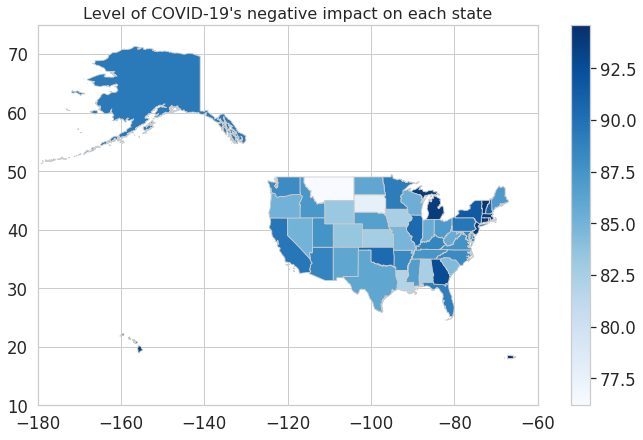

In [44]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Negative Impact'
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 7))
# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8',figsize=(10, 10))
plt.xlim(-180,-60);
plt.ylim(10,75);
plt.title("Level of COVID-19's negative impact on each state", fontsize=16);

To see an interactive version of this map, check my [Tableau dashboard](https://public.tableau.com/profile/xuan.lou#!/).

### Revenue
#### Q2) In the last week, did this business experience a change in operating revenues/sales/receipts, not including any financial assistance or loans?

**a)** First, we are going to see in general, how revenue has changed for small businesses.

In [45]:
#use the overall dataframe
q2_overall = return_input(overall, 2)
q2_overall_2 = return_input(overall_2, 2)
q2_overall_3 = return_input(overall_3, 2)
q2_overall_4 = return_input(overall_4, 2)
q2_overall_5 = return_input(overall_5, 2)
q2_overall_6 = return_input(overall_6, 2)
q2_overall_7 = return_input(overall_7, 2)
q2_overall_8 = return_input(overall_8, 2)
q2_overall_9 = return_input(overall_9, 2)

In [46]:
q2_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,2,1,0.059,0.18
1,-,2,2,0.740,0.28
2,-,2,3,0.201,0.43


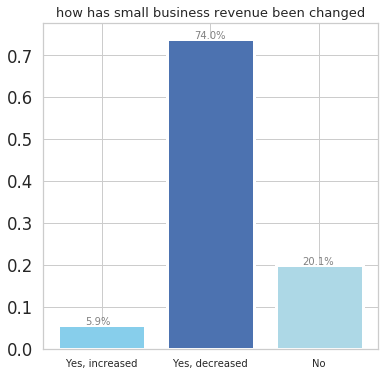

In [47]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(q2_overall.index,'Estimate Percentage', linewidth=3, data=q2_overall, color=['skyblue','b','lightblue']);
ax.set_title('how has small business revenue been changed',size=13)
positions = (0,1,2)
labels = ("Yes, increased", "Yes, decreased", "No")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

##### Weekly change (4/26-6/27)

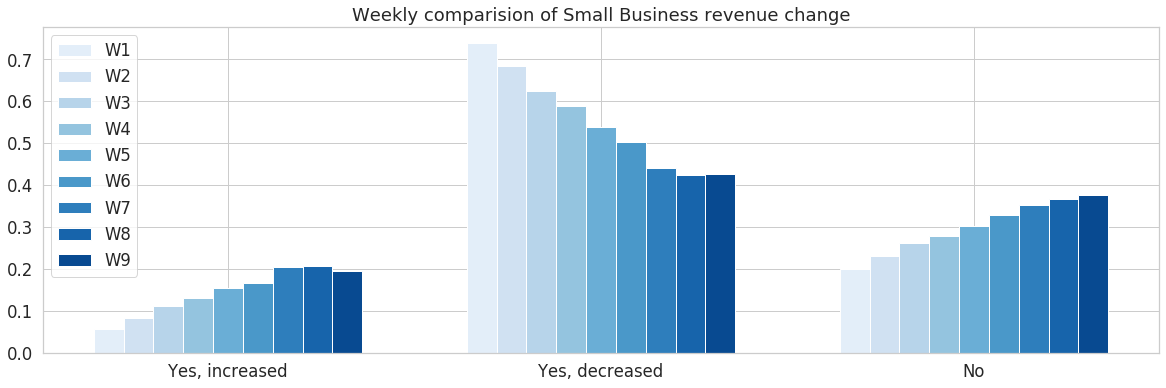

In [48]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(20,6))
plt.bar(q2_overall.index, q2_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q2_overall.index+width, q2_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q2_overall.index+width*2, q2_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q2_overall.index+width*3, q2_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q2_overall.index+width*4, q2_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q2_overall.index+width*5, q2_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q2_overall.index+width*6, q2_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q2_overall.index+width*7, q2_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q2_overall.index+width*8, q2_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Small Business revenue change')
positions = (0+width*4,1+width*4,2+width*4)
labels = ("Yes, increased", "Yes, decreased", "No")
plt.xticks(positions, labels);
plt.legend(loc='best')
plt.show()

Like the situation for negative impact, in this visualization we see that while **decreasing revenue remains prominent** through out the 9 weeks, more and **more small businesses have increase or no change in revenue**. In week 9, the amount of surveyed small businesses answered no change is approaching the amount of surveyed small businesses answered increase in revenue.

**b)** Now we are going explore how small businesses revenue has changed by state

In [49]:
#use the sbusiness dataframe which dropped the rows with overall info
q2 = return_input(sbusiness, 2)
q2_2 = return_input(sb_2, 2)
q2_3 = return_input(sb_3, 2)
q2_4 = return_input(sb_4, 2)
q2_5 = return_input(sb_5, 2)
q2_6 = return_input(sb_6, 2)
q2_7 = return_input(sb_7, 2)
q2_8 = return_input(sb_8, 2)
q2_9 = return_input(sb_9, 2)

In [50]:
q2

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,2,2,0.655,3.81
1,AK,2,3,0.255,3.98
2,AL,2,1,0.079,2.15
3,AL,2,2,0.695,3.07
4,AL,2,3,0.226,2.58
...,...,...,...,...,...
135,WI,2,3,0.249,1.28
136,WV,2,2,0.690,5.62
137,WV,2,3,0.218,5.20
138,WY,2,2,0.688,7.28


In [51]:
def decrease_revenue(table):
    d = table.loc[table['Answer ID']==2].sort_values(by='Estimate Percentage', ascending=False)
    d = d.rename(columns={'Estimate Percentage':'% SB having decrease in revenue'})
    return d

In [52]:
decreased = decrease_revenue(q2)
decreased_2 = decrease_revenue(q2_2)
decreased_3 = decrease_revenue(q2_3)
decreased_4 = decrease_revenue(q2_4)
decreased_5 = decrease_revenue(q2_5)
decreased_6 = decrease_revenue(q2_6)
decreased_7 = decrease_revenue(q2_7)
decreased_8 = decrease_revenue(q2_8)
decreased_9 = decrease_revenue(q2_9)
decreased_list = [decreased,decreased_2,decreased_3,decreased_4,decreased_5,decreased_6,decreased_7,decreased_8,
                  decreased_9]

In [53]:
decreased.head()

,State,Question ID,Answer ID,% SB having decrease in revenue,Standard Error
29,HI,2,2,0.811,4.67
85,NJ,2,2,0.805,1.84
107,PR,2,2,0.798,3.54
62,MI,2,2,0.797,2.36
47,KY,2,2,0.785,4.02


For the below analysis, change the `decreased` table so that you can see the information for a certain week. i.e. `decreased_2` for week2

In [54]:
most_decreased = decreased_9.iloc[0]['State']
most_percent = round(decreased_9.iloc[0]['% SB having decrease in revenue']*100,3)
least_decreased = decreased_9.iloc[decreased_9.shape[0]-1]['State']
least_percent = round(decreased_9.iloc[decreased_9.shape[0]-1]['% SB having decrease in revenue']*100,3)
print(f'Among 52 US states, {most_decreased} has the most amount of small business ({most_percent}%) that experienced a decrease in revenue.')
print(f'{least_decreased} has the least amount of small business ({least_percent}%) that experienced a decrease in revenue.')

Among 52 US states, PR has the most amount of small business (60.8%) that experienced a decrease in revenue.
MS has the least amount of small business (29.4%) that experienced a decrease in revenue.


In [55]:
above_50 = decreased_9.loc[decreased_9['% SB having decrease in revenue']>0.50].shape[0]
print(f'In {above_50} US states, the majority (>50%) of surveyed small businesses experienced a decrease in revenue')

In 3 US states, the majority (>50%) of surveyed small businesses experienced a decrease in revenue


In week 1, the **majority** (>50%) of small business in every state experienced a decrease in revenue. However, in week 9, every state has **less percent** of small business experienced a decrease in revenue.

#### Q3) In the last month, what were the total operating revenues/sales/receipts for this business, not including any financial assistance or loans?

**Note:** Although the survey is delivered to small business with recipts of $1000 or more, this question is asking for revenue `without any financial assistance`.

**a)** First, we are going to see the general distribution of small businesses revenue.

In [56]:
#use the overall dataframe
q3_overall = return_input(overall, 3)
q3_overall_2 = return_input(overall_2, 3)
q3_overall_3 = return_input(overall_3, 3)
q3_overall_4 = return_input(overall_4, 3)
q3_overall_5 = return_input(overall_5, 3)
q3_overall_6 = return_input(overall_6, 3)
q3_overall_7 = return_input(overall_7, 3)
q3_overall_8 = return_input(overall_8, 3)
q3_overall_9 = return_input(overall_9, 3)

In [57]:
q3_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,3,1,0.230,0.26
1,-,3,2,0.119,0.31
2,-,3,3,0.100,0.20
3,-,3,4,0.153,0.20
4,-,3,5,0.148,0.29
5,-,3,6,0.069,0.13
6,-,3,7,0.029,0.13
7,-,3,8,0.024,0.14
8,-,3,9,0.018,0.11
9,-,3,10,0.110,0.37


For the below visualizationn, change the `q3_overall` table so that you can see the information for a certain week. i.e. `q3_overall_2` for week2

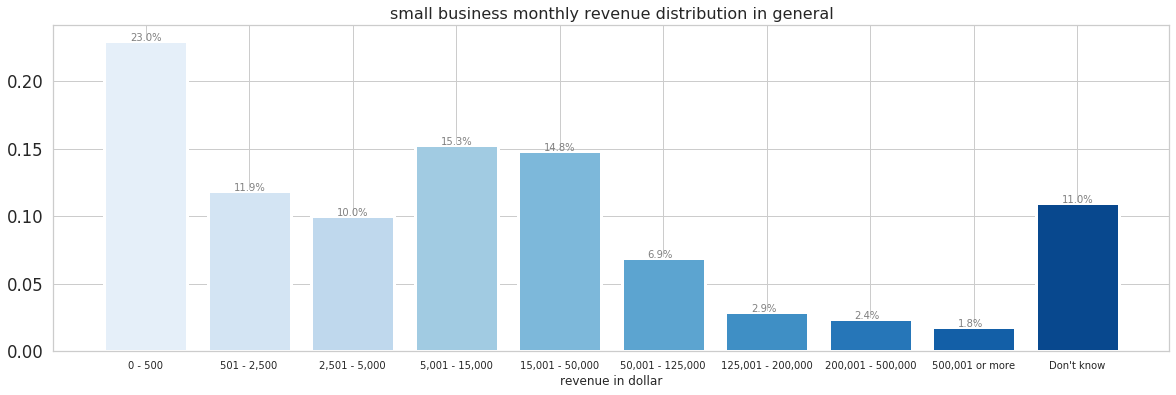

In [58]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(q3_overall.index,'Estimate Percentage', linewidth=3, data=q3_overall, color=sns.color_palette("Blues", 10));
ax.set_title('small business monthly revenue distribution in general',size=16)
positions = (0,1,2,3,4,5,6,7,8,9)
labels = ("0 - 500", "501 - 2,500", "2,501 - 5,000", "5,001 - 15,000", "15,001 - 50,000", 
         "50,001 - 125,000", "125,001 - 200,000", "200,001 - 500,000", "500,001 or more", "Don't know")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);
plt.xlabel('revenue in dollar',fontsize=12)

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

In [59]:
below_50000 = round(sum(q3_overall.iloc[0:4,:]['Estimate Percentage'])*100,1)
print(f'In week 1, the majority ({below_50000}%) of the small business have a monthly revenue lower than 50,000 dollar.')

In week 1, the majority (60.2%) of the small business have a monthly revenue lower than 50,000 dollar.


In [60]:
above_50000 = round(sum(q3_overall_9.iloc[4:8,:]['Estimate Percentage'])*100,1)
print(f'In week 9, the majority ({above_50000}%) of the small business have a monthly revenue higher than 50,000 dollar.')

In week 9, the majority (54.1%) of the small business have a monthly revenue higher than 50,000 dollar.


One thing that stands out in this visualization is that in week 1, the **lowest monthly revenue group (0-500)** has the **most amount, 23.0%** of the population. In week 9, the **middle monthly revenue group (15,001-50,000)** has the **most amount, 20.7%** of the population. This suggests that revenue is increasing.

##### Weekly change (4/26-6/27)

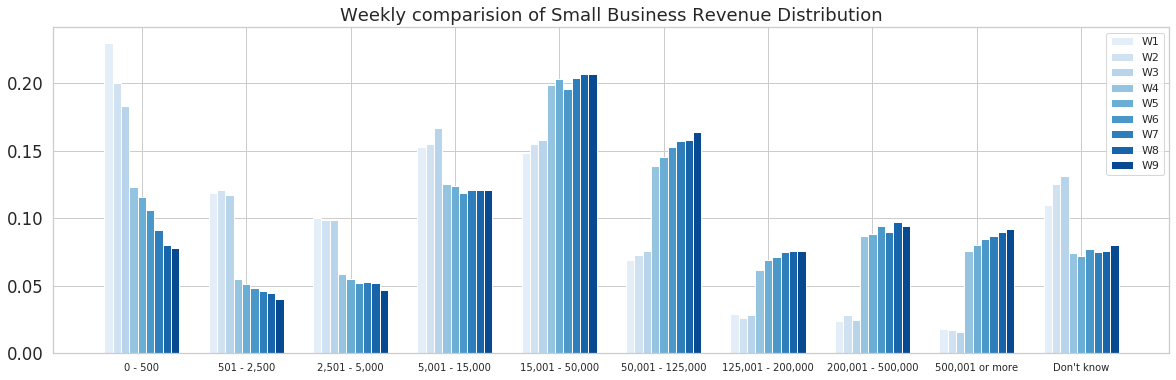

In [61]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(20,6))
plt.bar(q3_overall.index, q3_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q3_overall.index+width, q3_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q3_overall.index+width*2, q3_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q3_overall.index+width*3, q3_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q3_overall.index+width*4, q3_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q3_overall.index+width*5, q3_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q3_overall.index+width*6, q3_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q3_overall.index+width*7, q3_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q3_overall.index+width*8, q3_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Small Business Revenue Distribution')
positions = (0+width*4,1+width*4,2+width*4,3+width*4,4+width*4,5+width*4,6+width*4,7+width*4,8+width*4,9+width*4)
labels = ("0 - 500", "501 - 2,500", "2,501 - 5,000", "5,001 - 15,000", "15,001 - 50,000", 
         "50,001 - 125,000", "125,001 - 200,000", "200,001 - 500,000", "500,001 or more", "Don't know")
plt.xticks(positions, labels);
plt.xticks(fontsize=10)
plt.legend(loc='best', fontsize=11)
plt.show()

Percentage of small business in **lower revenue groups are decreasing**, whereas percentage of small business in **middle and high revenue group are increasing**.

**b)** Now we are going explore how monthly small businesses revenue is distributed by state

In [62]:
#use the sbusiness dataframe which dropped the rows with overall info
q3 = return_input(sbusiness, 3)
q3_2 = return_input(sb_2, 3)
q3_3 = return_input(sb_3, 3)
q3_4 = return_input(sb_4, 3)
q3_5 = return_input(sb_5, 3)
q3_6 = return_input(sb_6, 3)
q3_7 = return_input(sb_7, 3)
q3_8 = return_input(sb_8, 3)
q3_9 = return_input(sb_9, 3)

In [63]:
q3

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,3,1,0.319,4.04
1,AK,3,2,0.139,3.27
2,AK,3,5,0.120,4.87
3,AK,3,10,0.136,3.60
4,AL,3,1,0.176,3.80
...,...,...,...,...,...
392,WY,3,2,0.169,3.84
393,WY,3,3,0.135,4.54
394,WY,3,4,0.113,2.90
395,WY,3,5,0.201,7.06


##### Use the below function to see the monthly revenue distribution of a certain state's small business

change the `q3` table in the function so that you can see the information for a certain week. i.e. `q3_2` for week2

In [64]:
#input state postal code
def state_revenue_dist(state):
    s = q3.loc[q3['State']==state].groupby('Answer ID').mean()
    #print(s)
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    ax.bar(s.index,'Estimate Percentage', linewidth=3, data=s, color=sns.color_palette("Blues", 10));
    ax.set_title('small business monthly revenue distribution of '+ state,size=16)
    positions = (1,2,3,4,5,6,7,8,9,10)
    labels = ("0 - 500", "501 - 2,500", "2,501 - 5,000", "5,001 - 15,000", "15,001 - 50,000", 
             "50,001 - 125,000", "125,001 - 200,000", "200,001 - 500,000", "500,001 or more", "Don't know")
    plt.xticks(positions, labels);
    plt.xticks(fontsize=10);
    plt.xlabel('revenue in dollar',fontsize=12)

    # set individual bar lables 
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.25, i.get_height(), 
                str(round(i.get_height()*100, 2))+'%', fontsize=10,
                    color='grey')

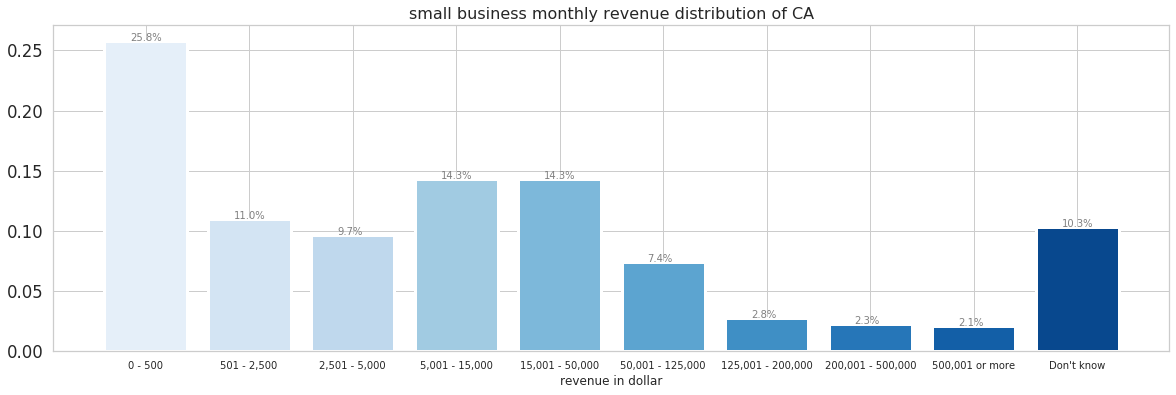

In [65]:
state_revenue_dist('CA')

behave the same with overall distribution

##### Small Business monthly revenue distribution map

In [66]:
#assign the mean of corresponding revenue group to each row
#Ex: if answer id is 1, which means revenue group is (0-500), then assign 250 to this row
def assign_revenue(series):
    array = []
    for x in series:
        if x == 1:
            array.append(250)
        elif x == 2:
            array.append(1500)
        elif x == 3:
            array.append(3750)
        elif x == 4:
            array.append(10000)
        elif x == 5:
            array.append(32500)
        elif x == 6:
            array.append(87500)
        elif x == 7:
            array.append(162500)
        elif x == 8:
            array.append(350000)
        elif x == 9:
            array.append(500000)
        #else:
            #array.append(0)
    return array

In [67]:
#the score defines the state's approximate mean small business revenue 
#sum(mean of revenue group * population percentage)
def revenue_score(table):
    score = table['Score'].to_list()
    percent = table['Estimate Percentage'].to_list()
    total = 0
    for i in score:
        revenue = percent[score.index(i)] * i
        total += revenue
    return total

In [68]:
#use the above functions to 
def approx_mean_revenue(table,f1,f2):
    #drop the rows with answer id 10, which the small business don't know its revenue
    no_0 = table.loc[table['Answer ID']==10].index
    new = table.drop(no_0).reset_index(drop=True)
    #use the above assign_revenue function to assign approximate revenue
    new['Score'] = f1(new['Answer ID'])
    #calculate the score for each state using the revenue_score function
    revenue = new.groupby('State').agg(f2)[['Score']].rename(columns={'Score':'Approx. Mean Revenue'})
    revenue['Full Name'] = full_name
    return revenue

In [69]:
revenue = approx_mean_revenue(q3,assign_revenue,revenue_score)
revenue_2 = approx_mean_revenue(q3_2,assign_revenue,revenue_score)
revenue_3 = approx_mean_revenue(q3_3,assign_revenue,revenue_score)
revenue_4 = approx_mean_revenue(q3_4,assign_revenue,revenue_score)
revenue_5 = approx_mean_revenue(q3_5,assign_revenue,revenue_score)
revenue_6 = approx_mean_revenue(q3_6,assign_revenue,revenue_score)
revenue_7 = approx_mean_revenue(q3_7,assign_revenue,revenue_score)
revenue_8 = approx_mean_revenue(q3_8,assign_revenue,revenue_score)
revenue_9 = approx_mean_revenue(q3_9,assign_revenue,revenue_score)
revenue_list = [revenue,revenue_2,revenue_3,revenue_4,revenue_5,revenue_6,revenue_7,revenue_8,revenue_9]

In [70]:
revenue.head()

,Approx. Mean Revenue,Full Name
State,,
AK,4188.25,Alaska
AL,29899.75,Alabama
AR,12858.75,Arkansas
AZ,17271.00,Arizona
CA,36245.75,California


change the `revenue` table to merge with map_df table so that you can see the revenue map for a certain week. i.e. `revenue_2` for week2

In [71]:
#merge the map_df dataframe with US_state dataframe
merged = map_df.set_index('NAME').merge(revenue, how='left', left_on="NAME", right_on="Full Name")
merged.head()

,GEO_ID,STATE,LSAD,CENSUSAREA,geometry,Approx. Mean Revenue,Full Name
0,0400000US01,01,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...",29899.75,Alabama
1,0400000US02,02,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752...",4188.25,Alaska
2,0400000US04,04,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",17271.00,Arizona
3,0400000US05,05,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079...",12858.75,Arkansas
4,0400000US06,06,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",36245.75,California


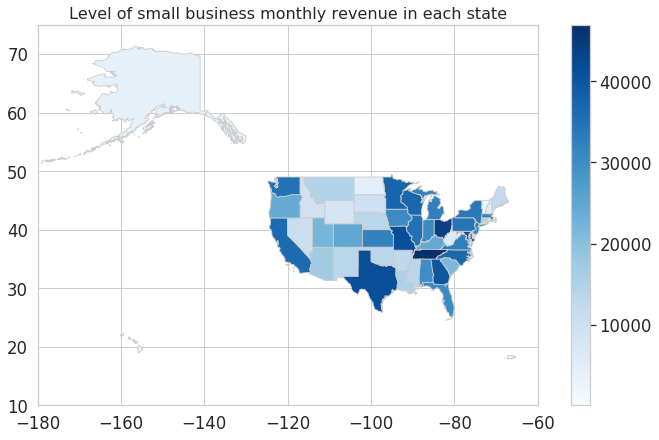

In [72]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Approx. Mean Revenue'
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 7))
# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8',figsize=(10, 10))
plt.xlim(-180,-60);
plt.ylim(10,75);
plt.title("Level of small business monthly revenue in each state", fontsize=16);

In week 1, monthly revenue distribution **varies** a lot across the country, whereas in week 9, the **majority** state has a **higher monthly revenue**.

**Note:** Although this is a very rough approximation of the mean revenue of each state's small business, but it shows a pretty accurate distribution of revenue levels. See below.

Comparison between state with light color (lower revenue) and dark color (higher revenue) in the map above.

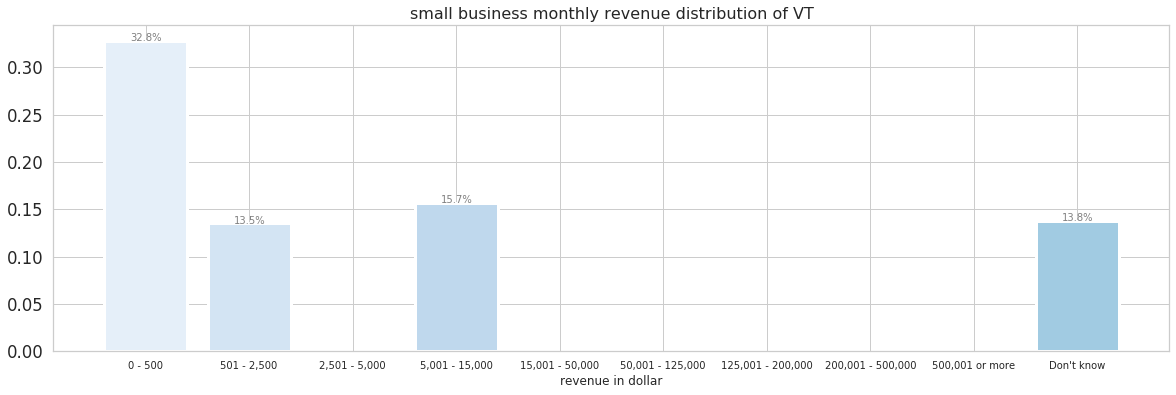

In [73]:
state_revenue_dist('VT')

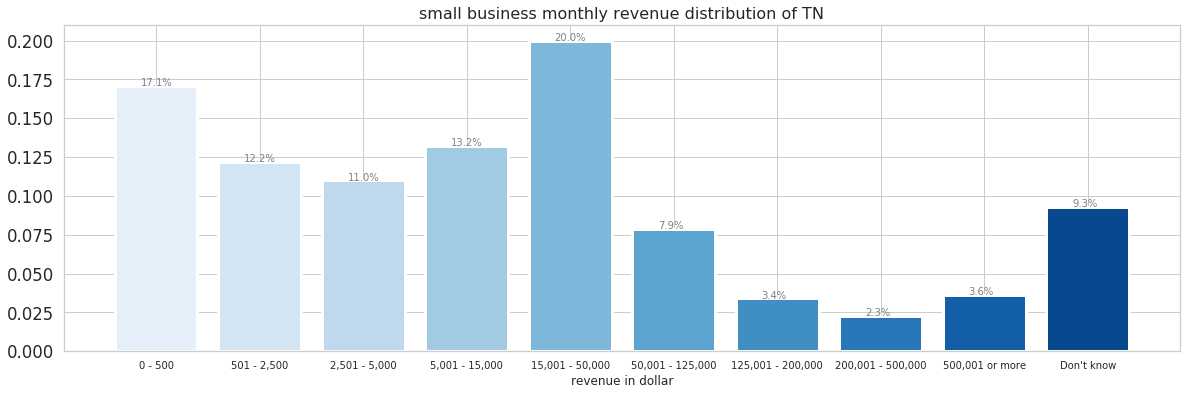

In [74]:
state_revenue_dist('TN')

To see a interactive version of Approximate Mean Revenue change across six weeks, check my [Tableau dashboard](https://public.tableau.com/profile/xuan.lou#!/).

### Operation
#### Q4) In the last week, did this business temporarily close any of its locations for at least one day?

**a)** First, we are going to see in general, how many small business temporarily closed for at least one day.

In [75]:
#use the overall dataframe
q4_overall = return_input(overall, 4)
q4_overall_2 = return_input(overall_2, 4)
q4_overall_3 = return_input(overall_3, 4)
q4_overall_4 = return_input(overall_4, 4)
q4_overall_5 = return_input(overall_5, 4)
q4_overall_6 = return_input(overall_6, 4)
q4_overall_7 = return_input(overall_7, 4)
q4_overall_8 = return_input(overall_8, 4)
q4_overall_9 = return_input(overall_9, 4)

In [76]:
q4_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,4,1,0.414,0.67
1,-,4,2,0.586,0.67


change the `q4_overall` table in the function so that you can see the information for a certain week. i.e. `q4_overall_2` for week2

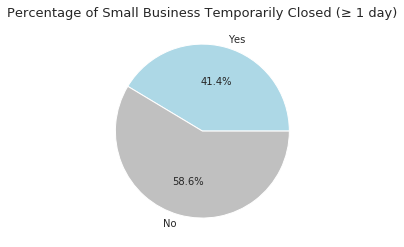

In [77]:
plt.pie(q4_overall['Estimate Percentage'], labels=['Yes','No'], colors=['lightblue','silver'], 
        textprops={'fontsize': 10},autopct='%1.1f%%');
plt.title('Percentage of Small Business Temporarily Closed (≥ 1 day)', fontsize=13);

##### Weekly change (4/26-6/27)

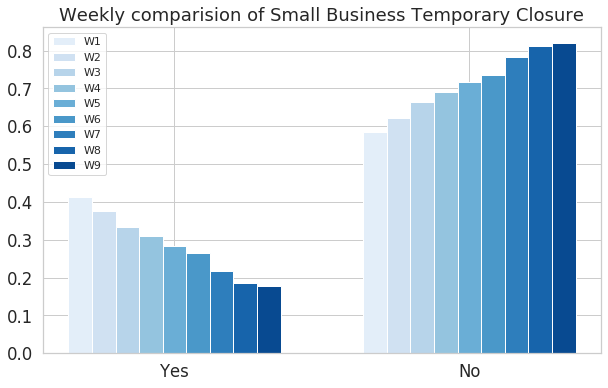

In [78]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(10,6))
plt.bar(q4_overall.index, q4_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q4_overall.index+width, q4_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q4_overall.index+width*2, q4_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q4_overall.index+width*3, q4_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q4_overall.index+width*4, q4_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q4_overall.index+width*5, q4_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q4_overall.index+width*6, q4_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q4_overall.index+width*7, q4_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q4_overall.index+width*8, q4_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Small Business Temporary Closure')
positions = (0+width*4,1+width*4)
labels = ('Yes','No')
plt.xticks(positions, labels);
plt.legend(loc='best', fontsize=11)
plt.show()

Percentage of small business having temporary closure **decrease**s over time whereas percentage of small business didn't experience temporary closure **increases**. The **majority (>50%) of small business answered no** across 9 weeks.

**b)** Now we are going to explore the percentage of small businesses experienced temporary closing in each state

In [79]:
#use the sbusiness dataframe which dropped the rows with overall info
q4 = return_input(sbusiness, 4)
q4_2 = return_input(sb_2, 4)
q4_3 = return_input(sb_3, 4)
q4_4 = return_input(sb_4, 4)
q4_5 = return_input(sb_5, 4)
q4_6 = return_input(sb_6, 4)
q4_7 = return_input(sb_7, 4)
q4_8 = return_input(sb_8, 4)
q4_9 = return_input(sb_9, 4)

In [80]:
q4

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,4,1,0.433,8.27
1,AK,4,2,0.567,8.27
2,AL,4,1,0.334,4.32
3,AL,4,2,0.666,4.32
4,AR,4,1,0.263,2.02
...,...,...,...,...,...
99,WI,4,2,0.630,2.57
100,WV,4,1,0.401,4.93
101,WV,4,2,0.599,4.93
102,WY,4,1,0.348,3.69


In [81]:
def temporary_closure(table):
    temp = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    temp = temp.rename(columns={'Estimate Percentage':'% SB close for at least one day'})
    return temp

In [82]:
tem_closed = temporary_closure(q4)
tem_closed_2 = temporary_closure(q4_2)
tem_closed_3 = temporary_closure(q4_3)
tem_closed_4 = temporary_closure(q4_4)
tem_closed_5 = temporary_closure(q4_5)
tem_closed_6 = temporary_closure(q4_6)
tem_closed_7 = temporary_closure(q4_7)
tem_closed_8 = temporary_closure(q4_8)
tem_closed_9 = temporary_closure(q4_9)
tem_closed_list = [tem_closed,tem_closed_2,tem_closed_3,tem_closed_4,tem_closed_5,tem_closed_6,tem_closed_7,
                   tem_closed_8,tem_closed_9]

In [83]:
tem_closed.head()

,State,Question ID,Answer ID,% SB close for at least one day,Standard Error
0,PR,4,1,0.767,4.34
1,DC,4,1,0.645,8.27
2,MI,4,1,0.588,2.52
3,PA,4,1,0.546,1.46
4,NY,4,1,0.545,1.51


For the below analysis, change the `tem_closed` table so that you can see the information for a certain week. i.e. `tem_closed_2` for week2

In [84]:
most_closed = tem_closed.iloc[0]['State']
most_percent = round(tem_closed.iloc[0]['% SB close for at least one day']*100,3)
least_closed = tem_closed.iloc[tem_closed.shape[0]-1]['State']
least_percent = round(tem_closed.iloc[tem_closed.shape[0]-1]['% SB close for at least one day']*100,3)
print(f'Among 52 US states, {most_closed}  has the most amount of small business ({most_percent}%) that experienced a temporary closure.')
print(f'{least_closed} has the least amount of small business ({least_percent}%) that experienced a temporary closure.')

Among 52 US states, PR  has the most amount of small business (76.7%) that experienced a temporary closure.
NE has the least amount of small business (20.0%) that experienced a temporary closure.


In [85]:
majority = tem_closed.loc[tem_closed['% SB close for at least one day']>0.5].shape[0]
mean = round(np.mean(tem_closed['% SB close for at least one day'])*100,1)
print(f'In {majority} out of 52 US states, more than 50% surveyed small businesses experienced temporary closure.')
print(f'The mean percentage of small business experienced temporary closure is {mean}%.')

In 6 out of 52 US states, more than 50% surveyed small businesses experienced temporary closure.
The mean percentage of small business experienced temporary closure is 39.3%.


Unlike the situation for decrease in revenue, where the majority of small business in every state experienced a decrease in revenue, the situation for temporary closure **varies** a lot across the country. **Most states** have **less then 50%** surveyed small business temporarily closed for at least one day.

#### Q7)  In the last week, did this business have disruptions in its supply chain?

**a)** First, we are going to see in general, how many small business have disruptions in its supply chain.

In [86]:
#use the overall dataframe
q7_overall = return_input(overall, 7)
q7_overall_2 = return_input(overall_2, 7)
q7_overall_3 = return_input(overall_3, 7)
q7_overall_4 = return_input(overall_4, 7)
q7_overall_5 = return_input(overall_5, 7)
q7_overall_6 = return_input(overall_6, 7)
q7_overall_7 = return_input(overall_7, 7)
q7_overall_8 = return_input(overall_8, 7)
q7_overall_9 = return_input(overall_9, 7)

In [87]:
q7_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,7,1,0.449,0.56
1,-,7,2,0.551,0.56


change the `q7_overall` table in the function so that you can see the information for a certain week. i.e. `q7_overall_2` for week2

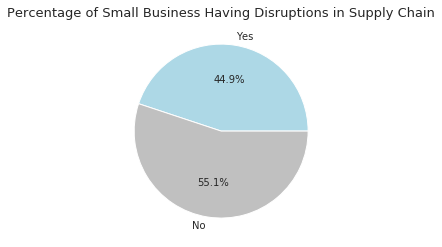

In [88]:
plt.pie(q7_overall['Estimate Percentage'], labels=['Yes','No'], colors=['lightblue','silver'], 
        textprops={'fontsize': 10},autopct='%1.1f%%');
plt.title('Percentage of Small Business Having Disruptions in Supply Chain', fontsize=13);

##### Weekly change (4/26-6/27)

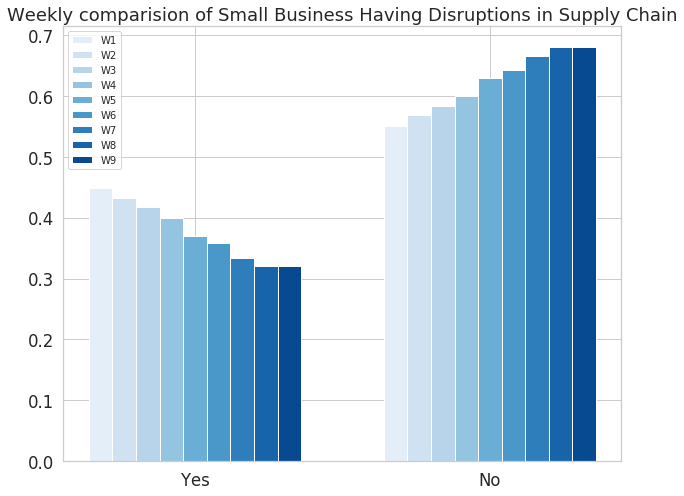

In [89]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(10,8))
plt.bar(q7_overall.index, q7_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q7_overall.index+width, q7_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q7_overall.index+width*2, q7_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q7_overall.index+width*3, q7_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q7_overall.index+width*4, q7_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q7_overall.index+width*5, q7_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q7_overall.index+width*6, q7_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q7_overall.index+width*7, q7_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q7_overall.index+width*8, q7_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Small Business Having Disruptions in Supply Chain')
positions = (0+width*4,1+width*4)
labels = ('Yes','No')
plt.xticks(positions, labels);
plt.legend(loc='best', fontsize=10)
plt.show()

Like the situation for temporary closure, the percentage of small business having disruptions in supply chain **decreases** over time whereas percentage of small business didn't experience disruptions in supply chain **increases**. The **majority (>50%) of small business answered no** across 9 weeks.

**b)** Now we are going to explore the percentage of small businesses having disruptions in supply chain in each state

In [90]:
#use the sbusiness dataframe which dropped the rows with overall info
q7 = return_input(sbusiness, 7)
q7_2 = return_input(sb_2, 7)
q7_3 = return_input(sb_3, 7)
q7_4 = return_input(sb_4, 7)
q7_5 = return_input(sb_5, 7)
q7_6 = return_input(sb_6, 7)
q7_7 = return_input(sb_7, 7)
q7_8 = return_input(sb_8, 7)
q7_9 = return_input(sb_9, 7)

In [91]:
q7

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,7,1,0.418,5.61
1,AK,7,2,0.582,5.61
2,AL,7,1,0.516,2.61
3,AL,7,2,0.484,2.61
4,AR,7,1,0.479,4.75
...,...,...,...,...,...
99,WI,7,2,0.540,3.07
100,WV,7,1,0.350,7.63
101,WV,7,2,0.650,7.63
102,WY,7,1,0.406,5.72


In [92]:
def disruption_supply(table):
    dis = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    dis = dis.rename(columns={'Estimate Percentage':'% SB having disruptions in supply chain'})
    return dis

In [93]:
disrupted = disruption_supply(q7)
disrupted_2 = disruption_supply(q7_2)
disrupted_3 = disruption_supply(q7_3)
disrupted_4 = disruption_supply(q7_4)
disrupted_5 = disruption_supply(q7_5)
disrupted_6 = disruption_supply(q7_6)
disrupted_7 = disruption_supply(q7_7)
disrupted_8 = disruption_supply(q7_8)
disrupted_9 = disruption_supply(q7_9)
disrupted_list = [disrupted,disrupted_2,disrupted_3,disrupted_4,disrupted_5,disrupted_6,disrupted_7,
                   disrupted_8,disrupted_9]

In [94]:
disrupted.head()

,State,Question ID,Answer ID,% SB having disruptions in supply chain,Standard Error
0,PR,7,1,0.677,3.24
1,MS,7,1,0.527,3.50
2,ME,7,1,0.517,3.52
3,AL,7,1,0.516,2.61
4,LA,7,1,0.510,5.15


For the below analysis, change the `disrupted` table so that you can see the information for a certain week. i.e. `disrupted_2` for week2.

In [95]:
most_disrupted = disrupted.iloc[0]['State']
most_percent = round(disrupted.iloc[0]['% SB having disruptions in supply chain']*100,3)
least_disrupted = disrupted.iloc[disrupted.shape[0]-1]['State']
least_percent = round(disrupted.iloc[disrupted.shape[0]-1]['% SB having disruptions in supply chain']*100,3)
print(f'Among 52 US states, {most_disrupted} has the most amount of small business ({most_percent}%) that experienced a disruption in supply chain.')
print(f'{least_disrupted} has the least amount of small business ({least_percent}%) that experienced a disruption in supply chain.')

Among 52 US states, PR has the most amount of small business (67.7%) that experienced a disruption in supply chain.
MT has the least amount of small business (28.3%) that experienced a disruption in supply chain.


In [96]:
majority = disrupted.loc[disrupted['% SB having disruptions in supply chain']>0.5].shape[0]
mean = round(np.mean(disrupted['% SB having disruptions in supply chain'])*100,1)
print(f'In {majority} out of 52 US states, more than 50% surveyed small businesses experienced disruption in supply chain.')
print(f'The mean percentage of small business experienced disruption in supply chain is {mean}%.')

In 5 out of 52 US states, more than 50% surveyed small businesses experienced disruption in supply chain.
The mean percentage of small business experienced disruption in supply chain is 44.2%.


Like the situation for temporary closure, the situation for disruption in supply chain also **varies** a lot across the country and **most states** have **less then 50%** surveyed small business experienced disrution in supply chain.

#### Q8)  In the last week, did this business shift to the production of other goods or services?

**a)** First, we are going to see in general, how many small business shifted to produce other goods or services.

In [97]:
#use the overall dataframe
q8_overall = return_input(overall, 8)
q8_overall_2 = return_input(overall_2, 8)
q8_overall_3 = return_input(overall_3, 8)
q8_overall_4 = return_input(overall_4, 8)
q8_overall_5 = return_input(overall_5, 8)
q8_overall_6 = return_input(overall_6, 8)
q8_overall_7 = return_input(overall_7, 8)
q8_overall_8 = return_input(overall_8, 8)
q8_overall_9 = return_input(overall_9, 8)

In [98]:
q8_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,8,1,0.068,0.24
1,-,8,2,0.932,0.24


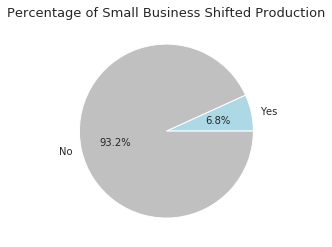

In [99]:
plt.pie(q8_overall['Estimate Percentage'], labels=['Yes','No'], colors=['lightblue','silver'], 
        textprops={'fontsize': 10},autopct='%1.1f%%');
plt.title('Percentage of Small Business Shifted Production', fontsize=13);

##### Weekly change (4/26-6/27)

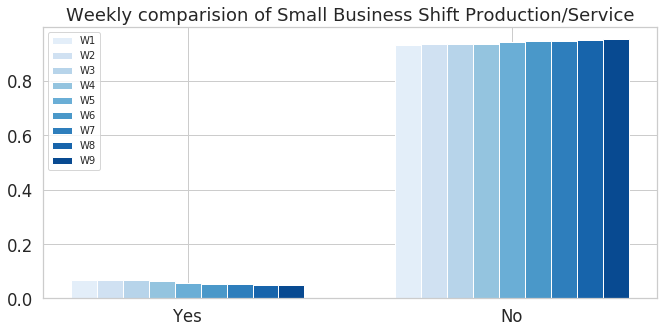

In [100]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(11,5))
plt.bar(q8_overall.index, q8_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q8_overall.index+width, q8_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q8_overall.index+width*2, q8_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q8_overall.index+width*3, q8_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q8_overall.index+width*4, q8_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q8_overall.index+width*5, q8_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q8_overall.index+width*6, q8_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q8_overall.index+width*7, q8_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q8_overall.index+width*8, q8_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Small Business Shift Production/Service')
positions = (0+width*4,1+width*4)
labels = ('Yes','No')
plt.xticks(positions, labels);
plt.legend(loc='best', fontsize=10)
plt.show()

Most Small Business **stick to the same goods/services** throughout the 9 weeks. Percent of small business shifting production/service **slightly decreases** over time whereas percentage of small business didn't experience disruptions in supply chain **slightly increases**. The **more than 80% of small business answered no** across 9 weeks.

**b)** Now we are going to explore the percentage of small businesses shifted production in each state.

In [101]:
#use the sbusiness dataframe which dropped the rows with overall info
q8 = return_input(sbusiness, 8)
q8_2 = return_input(sb_2, 8)
q8_3 = return_input(sb_3, 8)
q8_4 = return_input(sb_4, 8)
q8_5 = return_input(sb_5, 8)
q8_6 = return_input(sb_6, 8)
q8_7 = return_input(sb_7, 8)
q8_8 = return_input(sb_8, 8)
q8_9 = return_input(sb_9, 8)

In [102]:
q8

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,8,1,0.106,2.83
1,AK,8,2,0.894,2.83
2,AL,8,1,0.077,1.69
3,AL,8,2,0.923,1.69
4,AR,8,1,0.059,1.84
...,...,...,...,...,...
87,WA,8,2,0.928,0.99
88,WI,8,1,0.072,1.42
89,WI,8,2,0.928,1.42
90,WV,8,2,1.000,0.00


In [103]:
def shift_production(table):
    shift = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    shift = shift.rename(columns={'Estimate Percentage':'% SB shift production/services'})
    return shift

In [104]:
shifted = shift_production(q8)
shifted_2 = shift_production(q8_2)
shifted_3 = shift_production(q8_3)
shifted_4 = shift_production(q8_4)
shifted_5 = shift_production(q8_5)
shifted_6 = shift_production(q8_6)
shifted_7 = shift_production(q8_7)
shifted_8 = shift_production(q8_8)
shifted_9 = shift_production(q8_9)
shifted_list = [shifted,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,shifted_9]

In [105]:
shifted.head()

,State,Question ID,Answer ID,% SB shift production/services,Standard Error
0,PR,8,1,0.166,3.40
1,DC,8,1,0.129,4.29
2,AK,8,1,0.106,2.83
3,NH,8,1,0.095,3.04
4,HI,8,1,0.085,2.74


For the below analysis, change the `shifted` table so that you can see the information for a certain week. i.e. `shifted_2` for week2.

In [106]:
most_shifted = shifted.iloc[0]['State']
most_percent = round(shifted.iloc[0]['% SB shift production/services']*100,3)
least_shifted = shifted.iloc[shifted.shape[0]-1]['State']
least_percent = round(shifted.iloc[shifted.shape[0]-1]['% SB shift production/services']*100,3)
print(f'Among 52 US states, {most_shifted} has the most amount of small business ({most_percent}%) that shift production/services.')
print(f'{least_shifted} has the least amount of small business ({least_percent}%) that shift production/services.')

Among 52 US states, PR has the most amount of small business (16.6%) that shift production/services.
KS has the least amount of small business (4.2%) that shift production/services.


In [107]:
mean = round(np.mean(shifted['% SB shift production/services'])*100,1)
print(f'The mean percentage of small business shifted production/service is {mean}%.')

The mean percentage of small business shifted production/service is 7.3%.


**Every states** have **relatively low percent (<20%)** of surveyed small business shitfing their type of production/service throughout the 9 weeeks.

#### Q9) In the last week, did any of this business’s locations adopt pickup/carry-out/delivery as their only means of providing goods and services to their customers? 

**a)** First, we are going to see in general, how many small business only have pickup/carry-out/delivery.

In [108]:
#use the overall dataframe
q9_overall = return_input(overall, 9)
q9_overall_2 = return_input(overall_2, 9)
q9_overall_3 = return_input(overall_3, 9)
q9_overall_4 = return_input(overall_4, 9)
q9_overall_5 = return_input(overall_5, 9)
q9_overall_6 = return_input(overall_6, 9)
q9_overall_7 = return_input(overall_7, 9)
q9_overall_8 = return_input(overall_8, 9)
q9_overall_9 = return_input(overall_9, 9)

In [109]:
q9_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,9,1,0.152,0.7
1,-,9,2,0.848,0.7


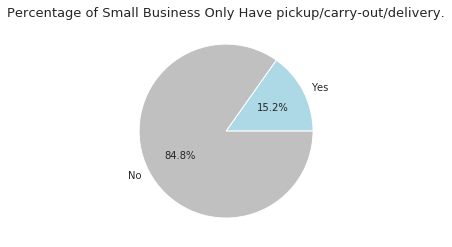

In [110]:
plt.pie(q9_overall['Estimate Percentage'], labels=['Yes','No'], colors=['lightblue','silver'], 
        textprops={'fontsize': 10},autopct='%1.1f%%');
plt.title('Percentage of Small Business Only Have pickup/carry-out/delivery.', fontsize=13);

Surprisingly, there is only **relative low percent** of small business that only do pickup/carry-out/delivery.

##### Weekly change (4/26-6/27)

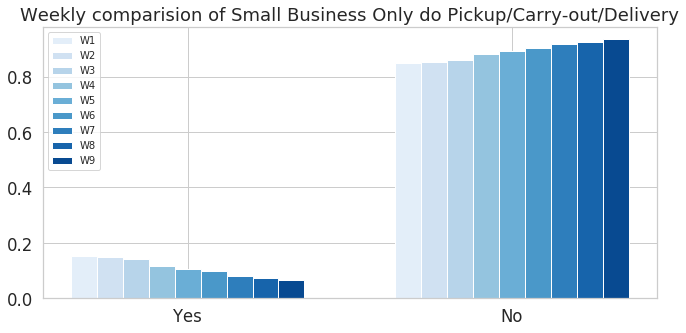

In [111]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(11,5))
plt.bar(q9_overall.index, q9_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q9_overall.index+width, q9_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q9_overall.index+width*2, q9_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q9_overall.index+width*3, q9_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q9_overall.index+width*4, q9_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q9_overall.index+width*5, q9_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q9_overall.index+width*6, q9_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q9_overall.index+width*7, q9_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q9_overall.index+width*8, q9_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Small Business Only do Pickup/Carry-out/Delivery')
positions = (0+width*4,1+width*4)
labels = ('Yes','No')
plt.xticks(positions, labels);
plt.legend(loc='best', fontsize=10)
plt.show()

Like the situation for shifting production/service, most small Business **stick to the same operarion type** throughout the 9 weeks and **less than 20% of small business only do pickup/carry-out/delivery**. Percent of small business only do pickup/carry-out/delivery **slightly decreases** over time whereas percentage of small business didn't only do pickup/carry-out/delivery **slightly increases**. 

**b)** Now we are going to explore the percentage of small businesses only have pickup/carry-out/delivery in each state.

In [112]:
#use the sbusiness dataframe which dropped the rows with overall info
q9 = return_input(sbusiness, 9)
q9_2 = return_input(sb_2, 9)
q9_3 = return_input(sb_3, 9)
q9_4 = return_input(sb_4, 9)
q9_5 = return_input(sb_5, 9)
q9_6 = return_input(sb_6, 9)
q9_7 = return_input(sb_7, 9)
q9_8 = return_input(sb_8, 9)
q9_9 = return_input(sb_9, 9)

In [113]:
q9

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,9,1,0.119,3.51
1,AK,9,2,0.881,3.51
2,AL,9,1,0.134,2.63
3,AL,9,2,0.866,2.63
4,AR,9,1,0.142,2.61
...,...,...,...,...,...
97,WI,9,1,0.166,1.94
98,WI,9,2,0.834,1.94
99,WV,9,2,0.926,4.22
100,WY,9,1,0.137,4.62


In [114]:
def only_pickup(table):
    only = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    only = only.rename(columns={'Estimate Percentage':'% SB only do pickup/delivery'})
    return only

In [115]:
pickup = only_pickup(q9)
pickup_2 = only_pickup(q9_2)
pickup_3 = only_pickup(q9_3)
pickup_4 = only_pickup(q9_4)
pickup_5 = only_pickup(q9_5)
pickup_6 = only_pickup(q9_6)
pickup_7 = only_pickup(q9_7)
pickup_8 = only_pickup(q9_8)
pickup_9 = only_pickup(q9_9)
pickup_list = [pickup,pickup_2,pickup_3,pickup_4,pickup_5,pickup_6,pickup_7,pickup_8,pickup_9]

In [116]:
pickup.head()

,State,Question ID,Answer ID,% SB only do pickup/delivery,Standard Error
0,PR,9,1,0.240,3.28
1,ND,9,1,0.224,4.58
2,KY,9,1,0.207,4.39
3,TN,9,1,0.205,3.04
4,LA,9,1,0.196,2.25


For the below analysis, change the `pickup` table so that you can see the information for a certain week. i.e. `pickup_2` for week2.

In [117]:
most_pickup = pickup.iloc[0]['State']
most_percent = round(pickup.iloc[0]['% SB only do pickup/delivery']*100,3)
least_pickup = pickup.iloc[pickup.shape[0]-1]['State']
least_percent = round(pickup.iloc[pickup.shape[0]-1]['% SB only do pickup/delivery']*100,3)
print(f'Among 52 US states, {most_pickup} has the most amount of small business ({most_percent}%) that only do pickup/delivery.')
print(f'{least_pickup} has the least amount of small business ({least_percent}%) that only do pickup/delivery.')

Among 52 US states, PR has the most amount of small business (24.0%) that only do pickup/delivery.
UT has the least amount of small business (11.0%) that only do pickup/delivery.


In [118]:
mean = round(np.mean(pickup['% SB only do pickup/delivery'])*100,1)
print(f'The mean percentage of small business only do pickup/delivery is {mean}%.')

The mean percentage of small business only do pickup/delivery is 15.6%.


**Every states** have **relatively low percent (<25%)** of surveyed small business only do pickup/delivery throughout the 9 weeeks.

#### Q15)  In your opinion, how much time do you think will pass before this business returns to its normal level of operations relative to one year ago?

**a)** First, we are going to see in general, how do small business predict the time it will take to return normal.

In [119]:
#use the overall dataframe
q15_overall = return_input(overall, 15)
q15_overall_2 = return_input(overall_2, 15)
q15_overall_3 = return_input(overall_3, 15)
q15_overall_4 = return_input(overall_4, 15)
q15_overall_5 = return_input(overall_5, 15)
q15_overall_6 = return_input(overall_6, 15)
q15_overall_7 = return_input(overall_7, 15)
q15_overall_8 = return_input(overall_8, 15)
q15_overall_9 = return_input(overall_9, 15)

In [120]:
q15_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,15,1,0.039,0.19
1,-,15,2,0.241,0.51
2,-,15,3,0.277,0.48
3,-,15,4,0.314,0.36
4,-,15,5,0.062,0.30
5,-,15,6,0.067,0.30


For the below visualizationn, change the `q15_overall` table so that you can see the information for a certain week. i.e. `q15_overall_2` for week2

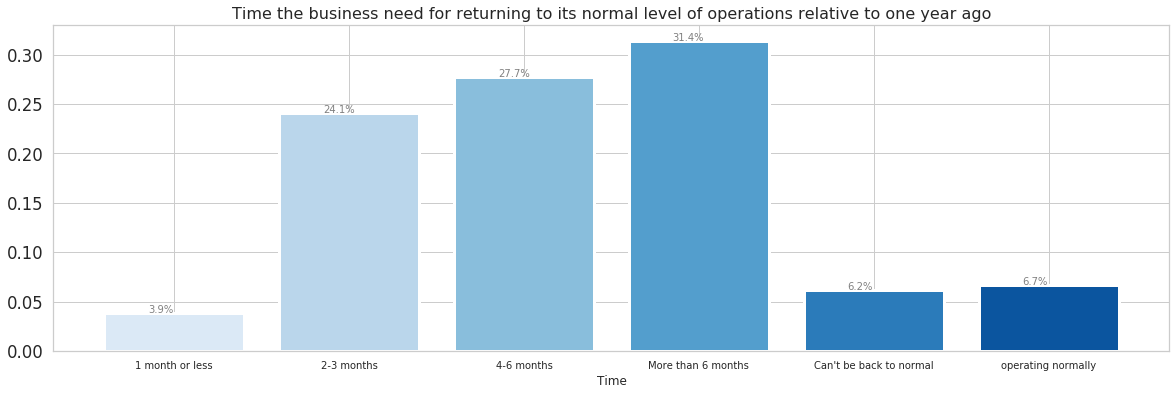

In [121]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(q15_overall.index,'Estimate Percentage', linewidth=3, data=q15_overall, color=sns.color_palette("Blues", 6));
ax.set_title('Time the business need for returning to its normal level of operations relative to one year ago',size=16)
positions = (0,1,2,3,4,5)
labels = ("1 month or less", "2-3 months", "4-6 months", "More than 6 months", "Can't be back to normal", 
         "operating normally")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);
plt.xlabel('Time',fontsize=12)

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

In [122]:
below_6 = round(sum(q15_overall.iloc[0:3,:]['Estimate Percentage'])*100,1)
print(f'In week 1, the majority ({below_6}%) of the small business needs less than 6 months to return normal.')

In week 1, the majority (55.7%) of the small business needs less than 6 months to return normal.


In [123]:
above_6 = round(sum(q15_overall_9.iloc[3:5,:]['Estimate Percentage'])*100,1)
print(f'In week 9, the majority ({above_6}%) of the small business have a monthly revenue higher than 50,000 dollar.')

In week 9, the majority (53.6%) of the small business have a monthly revenue higher than 50,000 dollar.


One thing that stands out in this visualization is that throughout 9 weeks, the **More than 6 months** has the **most amount** of the population, and it increase overtime from 31.4% to 43.9%.

##### Weekly change (4/26-6/27)

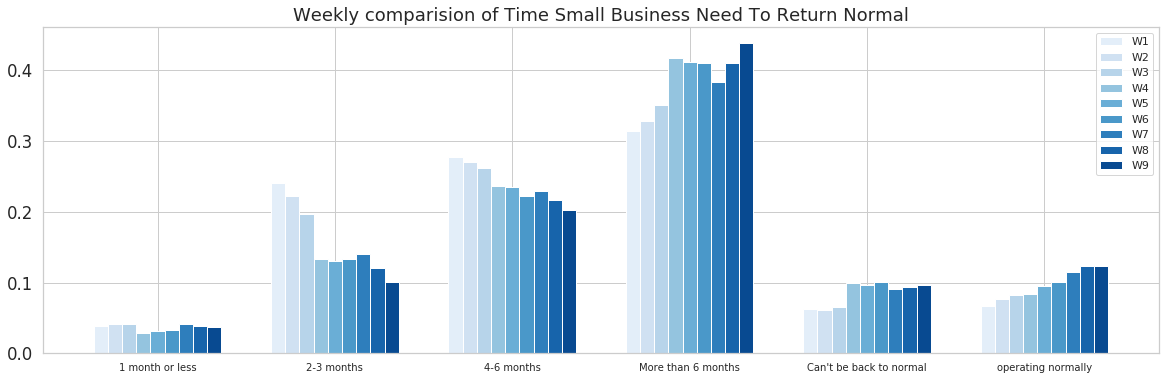

In [124]:
#side-by-side bar chart
width = 0.08
plt.figure(figsize=(20,6))
plt.bar(q15_overall.index, q15_overall['Estimate Percentage'].to_list(), width, label='W1', color=sns.color_palette("Blues", 9)[0])
plt.bar(q15_overall.index+width, q15_overall_2['Estimate Percentage'].to_list(), width, label='W2',color=sns.color_palette("Blues", 9)[1])
plt.bar(q15_overall.index+width*2, q15_overall_3['Estimate Percentage'].to_list(), width, label='W3',color=sns.color_palette("Blues", 9)[2])
plt.bar(q15_overall.index+width*3, q15_overall_4['Estimate Percentage'].to_list(), width, label='W4',color=sns.color_palette("Blues", 9)[3])
plt.bar(q15_overall.index+width*4, q15_overall_5['Estimate Percentage'].to_list(), width, label='W5',color=sns.color_palette("Blues", 9)[4])
plt.bar(q15_overall.index+width*5, q15_overall_6['Estimate Percentage'].to_list(), width, label='W6',color=sns.color_palette("Blues", 9)[5])
plt.bar(q15_overall.index+width*6, q15_overall_7['Estimate Percentage'].to_list(), width, label='W7',color=sns.color_palette("Blues", 9)[6])
plt.bar(q15_overall.index+width*7, q15_overall_8['Estimate Percentage'].to_list(), width, label='W8',color=sns.color_palette("Blues", 9)[7])
plt.bar(q15_overall.index+width*8, q15_overall_9['Estimate Percentage'].to_list(), width, label='W9',color=sns.color_palette("Blues", 9)[8])

plt.title('Weekly comparision of Time Small Business Need To Return Normal')
positions = (0+width*4,1+width*4,2+width*4,3+width*4,4+width*4,5+width*4)
labels = ("1 month or less", "2-3 months", "4-6 months", "More than 6 months", "Can't be back to normal", 
         "operating normally")
plt.xticks(positions, labels);
plt.xticks(fontsize=10)
plt.legend(loc='best', fontsize=11)
plt.show()

Percentage of small business in **shorter time groups are decreasing**, whereas percentage of small business in **longer time group are increasing**.

**b)** Now we are going to explore the time for small business to get back to normal in each state.

In [125]:
#use the sbusiness dataframe which dropped the rows with overall info
q15 = return_input(sbusiness, 15)
q15_2 = return_input(sb_2, 15)
q15_3 = return_input(sb_3, 15)
q15_4 = return_input(sb_4, 15)
q15_5 = return_input(sb_5, 15)
q15_6 = return_input(sb_6, 15)
q15_7 = return_input(sb_7, 15)
q15_8 = return_input(sb_8, 15)
q15_9 = return_input(sb_9, 15)

In [126]:
q15

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,15,2,0.284,6.17
1,AK,15,3,0.271,6.51
2,AK,15,4,0.327,7.05
3,AL,15,1,0.094,2.18
4,AL,15,2,0.310,3.62
...,...,...,...,...,...
257,WV,15,3,0.129,5.16
258,WV,15,4,0.182,3.70
259,WY,15,2,0.281,8.90
260,WY,15,3,0.234,7.01


In [127]:
def time(table):
    answer = table['Answer ID'].to_list()
    percent = table['Estimate Percentage'].to_list()
    total = 0
    for i in answer:
        if i == 1: 
            score = percent[answer.index(i)] * 1
        if i == 2:
            score = percent[answer.index(i)] * 2.5
        if i == 3:
            score = percent[answer.index(i)] * 5
        if i == 4:
            score = percent[answer.index(i)] * 6
        total += score
    return total

In [130]:
def time_backtonormal(table, function):
    t = table.groupby('State').agg(function)[['Estimate Percentage']].rename(columns={'Estimate Percentage':'Approx. Days Till Normal'})
    #time out of day
    t['Approx. Days Till Normal'] = t['Approx. Days Till Normal']*30
    return t

In [131]:
back_normal = time_backtonormal(q15,time)
back_normal_2 = time_backtonormal(q15_2,time)
back_normal_3 = time_backtonormal(q15_3,time)
back_normal_4 = time_backtonormal(q15_4,time)
back_normal_5 = time_backtonormal(q15_5,time)
back_normal_6 = time_backtonormal(q15_6,time)
back_normal_7 = time_backtonormal(q15_7,time)
back_normal_8 = time_backtonormal(q15_8,time)
back_normal_9 = time_backtonormal(q15_9,time)
back_normal_list = [back_normal,back_normal_2,back_normal_3,back_normal_4,back_normal_5,back_normal_6,back_normal_7,
                    back_normal_8,back_normal_9]

In [132]:
back_normal.head()

,Approx. Days Till Normal
State,
AK,120.810
AL,172.440
AR,159.195
AZ,240.570
CA,246.285


To see a interactive version of Approximate Days Till Normal across six weeks, check my [Tableau dashboard](https://public.tableau.com/profile/xuan.lou#!/).

### Employee
#### Q5)  In the last week, did this business have a change in the number of paid employees?

**a)** First, we are going to see in general, how the number of paid employees has changed for small businesses.

In [133]:
#use the overall dataframe
q5_overall = return_input(overall, 5)
q5_overall_2 = return_input(overall_2, 5)
q5_overall_3 = return_input(overall_3, 5)
q5_overall_4 = return_input(overall_4, 5)
q5_overall_5 = return_input(overall_5, 5)
q5_overall_6 = return_input(overall_6, 5)
q5_overall_7 = return_input(overall_7, 5)
q5_overall_8 = return_input(overall_8, 5)
q5_overall_9 = return_input(overall_9, 5)

In [134]:
q5_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,5,1,0.042,0.13
1,-,5,2,0.275,0.34
2,-,5,3,0.682,0.32


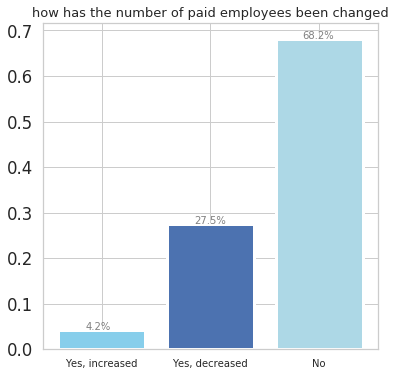

In [135]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(q5_overall.index,'Estimate Percentage', linewidth=3, data=q5_overall, color=['skyblue','b','lightblue']);
ax.set_title('how has the number of paid employees been changed',size=13)
positions = (0,1,2)
labels = ("Yes, increased", "Yes, decreased", "No")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

**b)** Now we are going explore how the number of paid employees has changed by state

In [136]:
#use the sbusiness dataframe which dropped the rows with overall info
q5 = return_input(sbusiness, 5)
q5_2 = return_input(sb_2, 5)
q5_3 = return_input(sb_3, 5)
q5_4 = return_input(sb_4, 5)
q5_5 = return_input(sb_5, 5)
q5_6 = return_input(sb_6, 5)
q5_7 = return_input(sb_7, 5)
q5_8 = return_input(sb_8, 5)
q5_9 = return_input(sb_9, 5)

In [137]:
q5

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,5,2,0.293,5.97
1,AK,5,3,0.606,6.52
2,AL,5,2,0.169,2.70
3,AL,5,3,0.805,2.61
4,AR,5,2,0.199,3.39
...,...,...,...,...,...
130,WI,5,3,0.703,1.92
131,WV,5,2,0.194,3.99
132,WV,5,3,0.780,4.05
133,WY,5,2,0.214,4.46


In [138]:
def decrease_paid_employee(table):
    d = table.loc[table['Answer ID']==2].sort_values(by='Estimate Percentage', ascending=False)
    d = d.rename(columns={'Estimate Percentage':'% SB having decrease in paid employee'})
    return d

In [139]:
employee = decrease_paid_employee(q5)
employee_2 = decrease_paid_employee(q5_2)
employee_3 = decrease_paid_employee(q5_3)
employee_4 = decrease_paid_employee(q5_4)
employee_5 = decrease_paid_employee(q5_5)
employee_6 = decrease_paid_employee(q5_6)
employee_7 = decrease_paid_employee(q5_7)
employee_8 = decrease_paid_employee(q5_8)
employee_9 = decrease_paid_employee(q5_9)
employee_list = [employee,employee_2,employee_3,employee_4,employee_5,employee_6,employee_7,employee_8,employee_9]

In [140]:
employee.head()

,State,Question ID,Answer ID,% SB having decrease in paid employee,Standard Error
103,PR,5,2,0.463,2.16
81,NJ,5,2,0.387,1.95
28,HI,5,2,0.373,3.94
101,PA,5,2,0.356,2.20
59,MI,5,2,0.354,1.71


In [141]:
most_decreased = employee.iloc[0]['State']
most_percent = round(employee.iloc[0]['% SB having decrease in paid employee']*100,3)
least_decreased = employee.iloc[employee.shape[0]-1]['State']
least_percent = round(employee.iloc[employee.shape[0]-1]['% SB having decrease in paid employee']*100,3)
print(f'Among 52 US states, {most_decreased} (Puerto Rico) has the most amount of small business ({most_percent}%) that experienced a decrease in paid employee.')
print(f'{least_decreased} (North Dakota) has the least amount of small business ({least_percent}%) that experienced a decrease in paid employee.')

Among 52 US states, PR (Puerto Rico) has the most amount of small business (46.3%) that experienced a decrease in paid employee.
ND (North Dakota) has the least amount of small business (12.2%) that experienced a decrease in paid employee.


We can see that for each state **less than 50%** of small business experienced a decrease in paid employee.

#### Q6)  In the last week, did this business have a change in the total number of hours worked by paid employees?

**a)** First, we are going to see in general, how the total number of hours worked by paid employees has changed for small businesses.

In [142]:
#use the overall dataframe
q6_overall = return_input(overall, 6)
q6_overall_2 = return_input(overall_2, 6)
q6_overall_3 = return_input(overall_3, 6)
q6_overall_4 = return_input(overall_4, 6)
q6_overall_5 = return_input(overall_5, 6)
q6_overall_6 = return_input(overall_6, 6)
q6_overall_7 = return_input(overall_7, 6)
q6_overall_8 = return_input(overall_8, 6)
q6_overall_9 = return_input(overall_9, 6)

In [143]:
q6_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,6,1,0.056,0.22
1,-,6,2,0.512,0.24
2,-,6,3,0.432,0.32


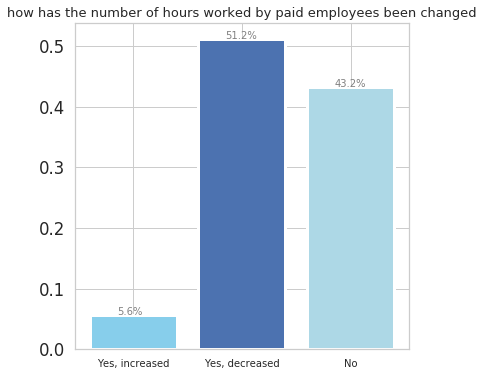

In [144]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(q6_overall.index,'Estimate Percentage', linewidth=3, data=q6_overall, color=['skyblue','b','lightblue']);
ax.set_title('how has the number of hours worked by paid employees been changed',size=13)
positions = (0,1,2)
labels = ("Yes, increased", "Yes, decreased", "No")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

**b)** Now we are going explore how the number of hours worked by paid employees has changed by state

In [145]:
#use the sbusiness dataframe which dropped the rows with overall info
q6 = return_input(sbusiness, 6)
q6_2 = return_input(sb_2, 6)
q6_3 = return_input(sb_3, 6)
q6_4 = return_input(sb_4, 6)
q6_5 = return_input(sb_5, 6)
q6_6 = return_input(sb_6, 6)
q6_7 = return_input(sb_7, 6)
q6_8 = return_input(sb_8, 6)
q6_9 = return_input(sb_9, 6)

In [146]:
q6

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,6,2,0.459,7.71
1,AK,6,3,0.427,9.27
2,AL,6,1,0.031,0.60
3,AL,6,2,0.453,2.86
4,AL,6,3,0.516,2.86
...,...,...,...,...,...
134,WI,6,3,0.450,2.42
135,WV,6,2,0.509,5.77
136,WV,6,3,0.405,6.25
137,WY,6,2,0.592,3.35


In [147]:
def decrease_work_hour(table):
    d = table.loc[table['Answer ID']==2].sort_values(by='Estimate Percentage', ascending=False)
    d = d.rename(columns={'Estimate Percentage':'% SB having decrease in paid employee work hours'})
    return d

In [148]:
employee_hour = decrease_work_hour(q6)
employee_hour_2 = decrease_work_hour(q6_2)
employee_hour_3 = decrease_work_hour(q6_3)
employee_hour_4 = decrease_work_hour(q6_4)
employee_hour_5 = decrease_work_hour(q6_5)
employee_hour_6 = decrease_work_hour(q6_6)
employee_hour_7 = decrease_work_hour(q6_7)
employee_hour_8 = decrease_work_hour(q6_8)
employee_hour_9 = decrease_work_hour(q6_9)
employee_hour_list = [employee_hour,employee_hour_2,employee_hour_3,employee_hour_4,employee_hour_5,employee_hour_6,
                      employee_hour_7,employee_hour_8,employee_hour_9]

In [149]:
employee_hour.head()

,State,Question ID,Answer ID,% SB having decrease in paid employee work hours,Standard Error
106,PR,6,2,0.774,3.41
87,NM,6,2,0.636,4.19
108,RI,6,2,0.629,5.86
62,MI,6,2,0.625,2.88
85,NJ,6,2,0.594,2.57


In [150]:
most_decreased = employee_hour.iloc[0]['State']
most_percent = round(employee_hour.iloc[0]['% SB having decrease in paid employee work hours']*100,3)
least_decreased = employee_hour.iloc[employee_hour.shape[0]-1]['State']
least_percent = round(employee_hour.iloc[employee_hour.shape[0]-1]['% SB having decrease in paid employee work hours']*100,3)
print(f'Among 52 US states, {most_decreased} (Puerto Rico) has the most amount of small business ({most_percent}%) that experienced a decrease in hours worked by paid employee.')
print(f'{least_decreased} (Montana) has the least amount of small business ({least_percent}%) that experienced a decrease in hours worked by paid employee.')

Among 52 US states, PR (Puerto Rico) has the most amount of small business (77.4%) that experienced a decrease in hours worked by paid employee.
MT (Montana) has the least amount of small business (30.6%) that experienced a decrease in hours worked by paid employee.


Unlike the decrease in number of paid employee, the situation for decrease in hours work by paid employee **varies** a lot across the country.

### Finance
#### Q10)  How would you describe the current availability of cash on hand for this business, including any financial assistance or loans? How long will cash on hand cover?

**a)** First, we are going to see in general, how do small business predict the time their cash on hand can cover.

In [151]:
#use the overall dataframe
q10_overall = return_input(overall, 10)
q10_overall_2 = return_input(overall_2, 10)
q10_overall_3 = return_input(overall_3, 10)
q10_overall_4 = return_input(overall_4, 10)
q10_overall_5 = return_input(overall_5, 10)
q10_overall_6 = return_input(overall_6, 10)
q10_overall_7 = return_input(overall_7, 10)
q10_overall_8 = return_input(overall_8, 10)
q10_overall_9 = return_input(overall_9, 10)

In [152]:
q10_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,10,1,0.095,0.20
1,-,10,2,0.138,0.21
2,-,10,3,0.179,0.19
3,-,10,4,0.248,0.43
4,-,10,5,0.167,0.28
5,-,10,6,0.068,0.22
6,-,10,7,0.104,0.13


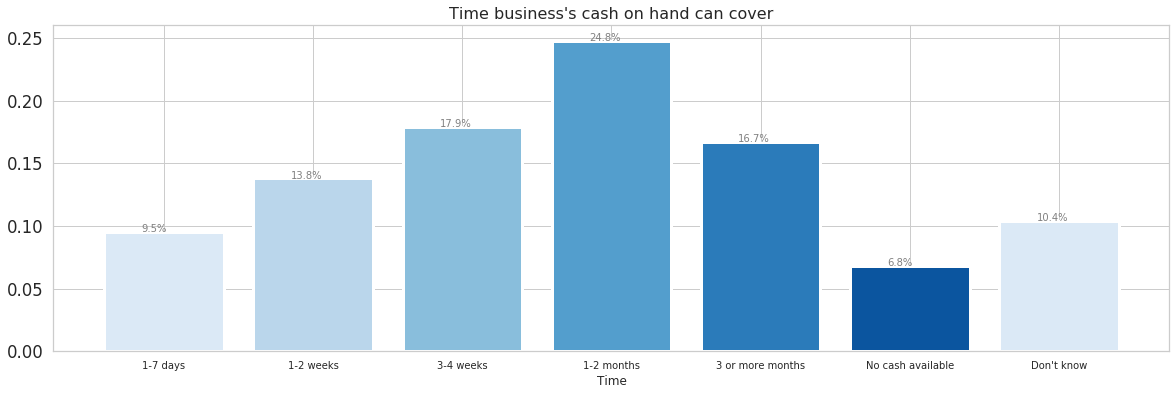

In [153]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(q10_overall.index,'Estimate Percentage', linewidth=3, data=q10_overall, color=sns.color_palette("Blues", 6));
ax.set_title("Time business's cash on hand can cover",size=16)
positions = (0,1,2,3,4,5,6)
labels = ("1-7 days", "1-2 weeks", "3-4 weeks", "1-2 months", "3 or more months", 
         "No cash available", "Don't know")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);
plt.xlabel('Time',fontsize=12)

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

**b)** Now we are going to explore the time small business's cash on hand can cover for each state.

In [154]:
#use the sbusiness dataframe which dropped the rows with overall info
q10 = return_input(sbusiness, 10)
q10_2 = return_input(sb_2, 10)
q10_3 = return_input(sb_3, 10)
q10_4 = return_input(sb_4, 10)
q10_5 = return_input(sb_5, 10)
q10_6 = return_input(sb_6, 10)
q10_7 = return_input(sb_7, 10)
q10_8 = return_input(sb_8, 10)
q10_9 = return_input(sb_9, 10)

In [155]:
q10

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,10,2,0.200,4.22
1,AK,10,3,0.119,2.18
2,AK,10,4,0.257,4.14
3,AK,10,5,0.196,3.63
4,AL,10,1,0.147,2.26
...,...,...,...,...,...
327,WV,10,5,0.189,6.00
328,WY,10,3,0.189,3.60
329,WY,10,4,0.348,5.66
330,WY,10,5,0.196,7.22


In [156]:
#ignore don't know & no cash on hand
def cover(table):
    answer = table['Answer ID'].to_list()
    percent = table['Estimate Percentage'].to_list()
    total = 0
    for i in answer:
        if i == 1: 
            score = percent[answer.index(i)] * 3.5
        if i == 2:
            score = percent[answer.index(i)] * 1.5 * 7
        if i == 3:
            score = percent[answer.index(i)] * 3.5 * 7
        if i == 4:
            score = percent[answer.index(i)] * 1.5 * 30
        if i == 5:
            score = percent[answer.index(i)] * 3 * 30
        total += score
    return total

In [157]:
def time_cashcancover(table, function):
    t = table.groupby('State').agg(function)[['Estimate Percentage']].rename(columns={'Estimate Percentage':
    'Approx. Days Cash on Hand Can Cover'})
    return t

In [158]:
cash = time_cashcancover(q10,cover)
cash_2 = time_cashcancover(q10_2,cover)
cash_3 = time_cashcancover(q10_3,cover)
cash_4 = time_cashcancover(q10_4,cover)
cash_5 = time_cashcancover(q10_5,cover)
cash_6 = time_cashcancover(q10_6,cover)
cash_7 = time_cashcancover(q10_7,cover)
cash_8 = time_cashcancover(q10_8,cover)
cash_9 = time_cashcancover(q10_9,cover)
cash_list = [cash,cash_2,cash_3,cash_4,cash_5,cash_6,cash_7,cash_8,cash_9]

In [159]:
cash.head()

,Approx. Days Cash on Hand Can Cover
State,
AK,34.2205
AL,46.5845
AR,50.7230
AZ,66.3725
CA,62.6350


#### Q11) The White House declared a national emergency because of the COVID-19 pandemic on March 13, 2020. Since then, has this business missed any loan payments? Loan payments that have been forgiven or postponed should not be considered to be missed.

**a)** First, we are going to see in general, how many small business have missed any loan payments.

In [160]:
#use the overall dataframe
q11_overall = return_input(overall, 11)
q11_overall_2 = return_input(overall_2, 11)
q11_overall_3 = return_input(overall_3, 11)
q11_overall_4 = return_input(overall_4, 11)
q11_overall_5 = return_input(overall_5, 11)
q11_overall_6 = return_input(overall_6, 11)
q11_overall_7 = return_input(overall_7, 11)
q11_overall_8 = return_input(overall_8, 11)
q11_overall_9 = return_input(overall_9, 11)

In [161]:
q11_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,11,1,0.115,0.41
1,-,11,2,0.885,0.41


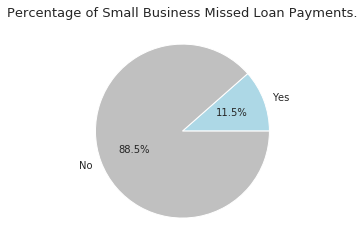

In [162]:
plt.pie(q11_overall['Estimate Percentage'], labels=['Yes','No'], colors=['lightblue','silver'], 
        textprops={'fontsize': 10},autopct='%1.1f%%');
plt.title('Percentage of Small Business Missed Loan Payments.', fontsize=13);

Most small business surveyed are doing fine with loan payments. There is only **11.5%** small business that have missed loan payments.

**b)** Now we are going to explore the percentage of small businesses missed loan payments in each state.

In [163]:
#use the sbusiness dataframe which dropped the rows with overall info
q11 = return_input(sbusiness, 11)
q11_2 = return_input(sb_2, 11)
q11_3 = return_input(sb_3, 11)
q11_4 = return_input(sb_4, 11)
q11_5 = return_input(sb_5, 11)
q11_6 = return_input(sb_6, 11)
q11_7 = return_input(sb_7, 11)
q11_8 = return_input(sb_8, 11)
q11_9 = return_input(sb_9, 11)

In [164]:
q11

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,11,2,0.922,2.31
1,AL,11,1,0.106,1.52
2,AL,11,2,0.894,1.52
3,AR,11,1,0.077,1.93
4,AR,11,2,0.923,1.93
...,...,...,...,...,...
91,WA,11,2,0.902,1.18
92,WI,11,1,0.086,1.32
93,WI,11,2,0.914,1.32
94,WV,11,2,0.902,5.95


In [165]:
def miss_loanpayment(table):
    miss = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    miss = miss.rename(columns={'Estimate Percentage':'% SB missed loan payment'})
    return miss

In [166]:
miss_loan = miss_loanpayment(q11)
miss_loan_2 = miss_loanpayment(q11_2)
miss_loan_3 = miss_loanpayment(q11_3)
miss_loan_4 = miss_loanpayment(q11_4)
miss_loan_5 = miss_loanpayment(q11_5)
miss_loan_6 = miss_loanpayment(q11_6)
miss_loan_7 = miss_loanpayment(q11_7)
miss_loan_8 = miss_loanpayment(q11_8)
miss_loan_9 = miss_loanpayment(q11_9)
miss_loan_list = [miss_loan,miss_loan_2,miss_loan_3,miss_loan_4,miss_loan_5,miss_loan_6,miss_loan_7,miss_loan_8,
                  miss_loan_9]

In [167]:
miss_loan.head()

,State,Question ID,Answer ID,% SB missed loan payment,Standard Error
0,PR,11,1,0.200,4.00
1,DC,11,1,0.177,5.38
2,PA,11,1,0.148,0.83
3,MI,11,1,0.142,1.72
4,NJ,11,1,0.140,1.62


#### Q12)  Since March 13, 2020, has this business missed any other scheduled payments, not including loans? Examples of other scheduled payments include rent, utilities, and payroll. Scheduled payments that have been forgiven or postponed should not be considered to be missed.

**a)** First, we are going to see in general, how many small business have missed any other shceduled payments.

In [168]:
#use the overall dataframe
q12_overall = return_input(overall, 12)
q12_overall_2 = return_input(overall_2, 12)
q12_overall_3 = return_input(overall_3, 12)
q12_overall_4 = return_input(overall_4, 12)
q12_overall_5 = return_input(overall_5, 12)
q12_overall_6 = return_input(overall_6, 12)
q12_overall_7 = return_input(overall_7, 12)
q12_overall_8 = return_input(overall_8, 12)
q12_overall_9 = return_input(overall_9, 12)

In [169]:
q12_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,12,1,0.236,0.68
1,-,12,2,0.764,0.68


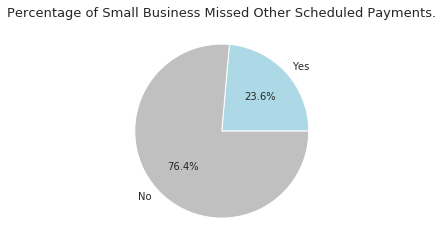

In [170]:
plt.pie(q12_overall['Estimate Percentage'], labels=['Yes','No'], colors=['lightblue','silver'], 
        textprops={'fontsize': 10},autopct='%1.1f%%');
plt.title('Percentage of Small Business Missed Other Scheduled Payments.', fontsize=13);

Like the situation for loan payments, most small business surveyed are doing fine with other scheduled payments. There is only **23.6%** small business that have missed other scheduled payments.

**b)** Now we are going to explore the percentage of small businesses missed other scheduled payments in each state.

In [171]:
#use the sbusiness dataframe which dropped the rows with overall info
q12 = return_input(sbusiness, 12)
q12_2 = return_input(sb_2, 12)
q12_3 = return_input(sb_3, 12)
q12_4 = return_input(sb_4, 12)
q12_5 = return_input(sb_5, 12)
q12_6 = return_input(sb_6, 12)
q12_7 = return_input(sb_7, 12)
q12_8 = return_input(sb_8, 12)
q12_9 = return_input(sb_9, 12)

In [172]:
q12

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,12,1,0.214,4.63
1,AK,12,2,0.786,4.63
2,AL,12,1,0.171,1.90
3,AL,12,2,0.829,1.90
4,AR,12,1,0.169,2.89
...,...,...,...,...,...
96,WI,12,1,0.169,2.11
97,WI,12,2,0.831,2.11
98,WV,12,1,0.288,7.33
99,WV,12,2,0.712,7.33


In [173]:
def miss_otherpayment(table):
    miss_o = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    miss_o = miss_o.rename(columns={'Estimate Percentage':'% SB missed other scheduled payment'})
    return miss_o

In [174]:
miss_payment = miss_otherpayment(q12)
miss_payment_2 = miss_otherpayment(q12_2)
miss_payment_3 = miss_otherpayment(q12_3)
miss_payment_4 = miss_otherpayment(q12_4)
miss_payment_5 = miss_otherpayment(q12_5)
miss_payment_6 = miss_otherpayment(q12_6)
miss_payment_7 = miss_otherpayment(q12_7)
miss_payment_8 = miss_otherpayment(q12_8)
miss_payment_9 = miss_otherpayment(q12_9)
miss_payment_list = [miss_payment,miss_payment_2,miss_payment_3,miss_payment_4,miss_payment_5,miss_payment_6,
                     miss_payment_7,miss_payment_8,miss_payment_9]

In [175]:
miss_payment.head()

,State,Question ID,Answer ID,% SB missed other scheduled payment,Standard Error
0,PR,12,1,0.471,5.72
1,NY,12,1,0.350,1.82
2,DC,12,1,0.337,7.88
3,NJ,12,1,0.337,1.84
4,WV,12,1,0.288,7.33


#### Q13)  Since March 13, 2020, has this business requested financial assistance? 

**a)** First, we are going to see in general, what financial assistance small business has requested.

In [176]:
#use the overall dataframe
q13_overall = return_input(overall, 13)
q13_overall_2 = return_input(overall_2, 13)
q13_overall_3 = return_input(overall_3, 13)
q13_overall_4 = return_input(overall_4, 13)
q13_overall_5 = return_input(overall_5, 13)
q13_overall_6 = return_input(overall_6, 13)
q13_overall_7 = return_input(overall_7, 13)
q13_overall_8 = return_input(overall_8, 13)
q13_overall_9 = return_input(overall_9, 13)

In [177]:
q13_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,13,1,0.749,0.59
1,-,13,2,0.293,0.72
2,-,13,3,0.102,0.24
3,-,13,4,0.021,0.13
4,-,13,5,0.049,0.21
5,-,13,6,0.095,0.25
6,-,13,7,0.127,0.46
7,-,13,8,0.049,0.24
8,-,13,9,0.037,0.14
9,-,13,10,0.173,0.46


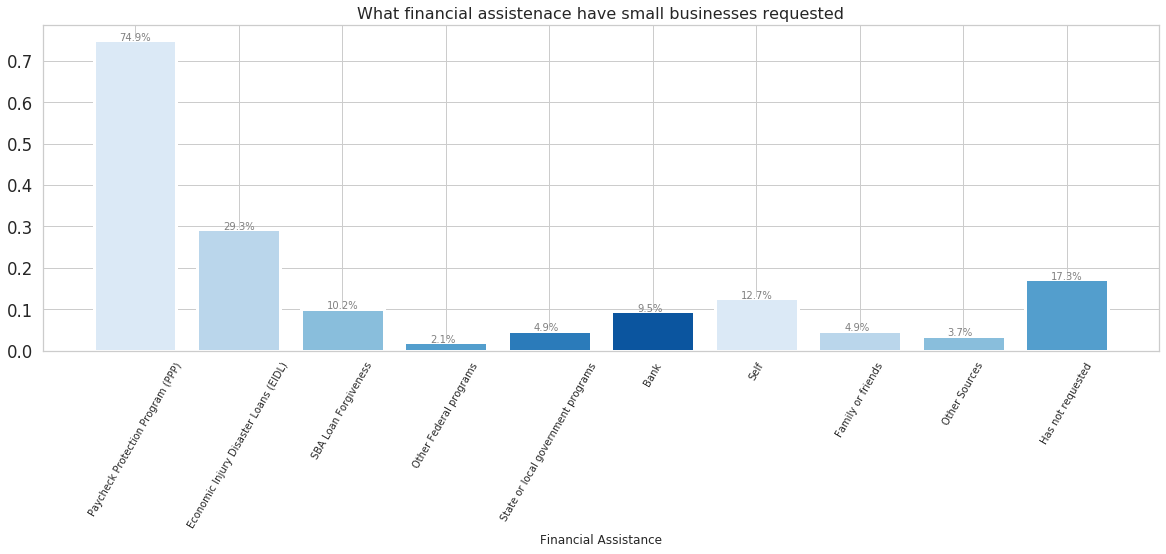

In [178]:
#Paycheck Protection Program (PPP)
#Economic Injury Disaster Loans (EIDL)
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(q13_overall.index,'Estimate Percentage', linewidth=3, data=q13_overall, color=sns.color_palette("Blues", 6));
ax.set_title("What financial assistenace have small businesses requested",size=16)
positions = (0,1,2,3,4,5,6,7,8,9)
labels = ("Paycheck Protection Program (PPP)", "Economic Injury Disaster Loans (EIDL)", "SBA Loan Forgiveness", 
          "Other Federal programs", "State or local government programs", 'Bank', 'Self', 'Family or friends',
         "Other Sources", "Has not requested")
plt.xticks(positions, labels);
plt.xticks(fontsize=10,rotation=60);
plt.xlabel('Financial Assistance',fontsize=12)

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

**b)** Now we are going to explore what financial assistance small business from each state has requested.

In [179]:
#use the sbusiness dataframe which dropped the rows with overall info
q13 = return_input(sbusiness, 13)
q13_2 = return_input(sb_2, 13)
q13_3 = return_input(sb_3, 13)
q13_4 = return_input(sb_4, 13)
q13_5 = return_input(sb_5, 13)
q13_6 = return_input(sb_6, 13)
q13_7 = return_input(sb_7, 13)
q13_8 = return_input(sb_8, 13)
q13_9 = return_input(sb_9, 13)

In [180]:
q13

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,13,1,0.691,6.22
1,AK,13,2,0.308,5.06
2,AK,13,7,0.132,3.87
3,AK,13,10,0.215,5.46
4,AL,13,1,0.760,3.59
...,...,...,...,...,...
372,WV,13,2,0.314,6.14
373,WV,13,10,0.224,4.03
374,WY,13,1,0.568,5.08
375,WY,13,2,0.154,4.72


In [181]:
def PPP(table):
    p = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    p = p.rename(columns={'Estimate Percentage':'% SB requested financial assistance from PPP'})
    return p

In [182]:
request_PPP = PPP(q13)
request_PPP_2 = PPP(q13_2)
request_PPP_3 = PPP(q13_3)
request_PPP_4 = PPP(q13_4)
request_PPP_5 = PPP(q13_5)
request_PPP_6 = PPP(q13_6)
request_PPP_7 = PPP(q13_7)
request_PPP_8 = PPP(q13_8)
request_PPP_9 = PPP(q13_9)
request_PPP_list = [request_PPP,request_PPP_2,request_PPP_3,request_PPP_4,request_PPP_5,request_PPP_6,
                     request_PPP_7,request_PPP_8,request_PPP_9]

In [183]:
request_PPP.head()

,State,Question ID,Answer ID,% SB requested financial assistance from PPP,Standard Error
0,ME,13,1,0.800,4.37
1,OK,13,1,0.797,2.51
2,GA,13,1,0.791,2.60
3,AR,13,1,0.790,3.76
4,NJ,13,1,0.785,0.70


In [184]:
most_requested = request_PPP.iloc[0]['State']
most_percent = round(request_PPP.iloc[0]['% SB requested financial assistance from PPP']*100,3)
least_requested = request_PPP.iloc[request_PPP.shape[0]-1]['State']
least_percent = round(request_PPP.iloc[request_PPP.shape[0]-1]['% SB requested financial assistance from PPP']*100,3)
print(f'Among 52 US states, {most_requested} (Maine) has the most amount of small business ({most_percent}%) that requested financial assistance from PPP.')
print(f'{least_requested} (Puerto Rico) has the least amount of small business ({least_percent}%) that requested financial assistance from PPP.')

Among 52 US states, ME (Maine) has the most amount of small business (80.0%) that requested financial assistance from PPP.
PR (Puerto Rico) has the least amount of small business (56.7%) that requested financial assistance from PPP.


We can see that in **every state**, the **majority** of small business has requested financial assistance from Paycheck Protection Program (PPP).

#### Q14)   Since March 13, 2020, has this business received financial assistance? 

**a)** First, we are going to see in general, what financial assistance small business has receieved.

In [185]:
#use the overall dataframe
q14_overall = return_input(overall, 14)
q14_overall_2 = return_input(overall_2, 14)
q14_overall_3 = return_input(overall_3, 14)
q14_overall_4 = return_input(overall_4, 14)
q14_overall_5 = return_input(overall_5, 14)
q14_overall_6 = return_input(overall_6, 14)
q14_overall_7 = return_input(overall_7, 14)
q14_overall_8 = return_input(overall_8, 14)
q14_overall_9 = return_input(overall_9, 14)

In [186]:
q14_overall

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,-,14,1,0.381,0.31
1,-,14,2,0.101,0.41
2,-,14,3,0.034,0.13
3,-,14,4,0.018,0.14
4,-,14,5,0.536,0.36


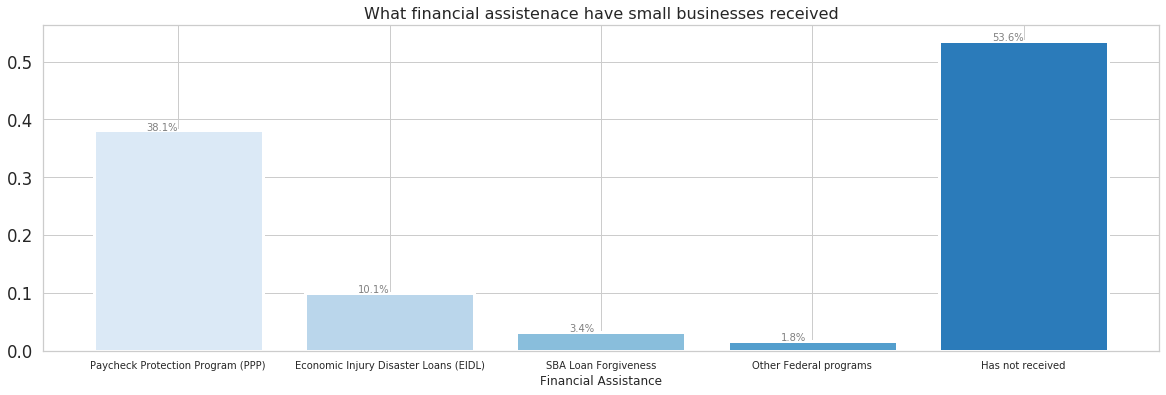

In [187]:
#Paycheck Protection Program (PPP)
#Economic Injury Disaster Loans (EIDL)
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(q14_overall.index,'Estimate Percentage', linewidth=3, data=q14_overall, color=sns.color_palette("Blues", 6));
ax.set_title("What financial assistenace have small businesses received",size=16)
positions = (0,1,2,3,4)
labels = ("Paycheck Protection Program (PPP)", "Economic Injury Disaster Loans (EIDL)", "SBA Loan Forgiveness", 
          "Other Federal programs", "Has not received")
plt.xticks(positions, labels);
plt.xticks(fontsize=10);
plt.xlabel('Financial Assistance',fontsize=12)

# set individual bar lables 
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.25, i.get_height(), 
            str(round(i.get_height()*100, 2))+'%', fontsize=10,
                color='grey')

**b)** Now we are going to explore what financial assistance small business from each state has requested.

In [188]:
#use the sbusiness dataframe which dropped the rows with overall info
q14 = return_input(sbusiness, 14)
q14_2 = return_input(sb_2, 14)
q14_3 = return_input(sb_3, 14)
q14_4 = return_input(sb_4, 14)
q14_5 = return_input(sb_5, 14)
q14_6 = return_input(sb_6, 14)
q14_7 = return_input(sb_7, 14)
q14_8 = return_input(sb_8, 14)
q14_9 = return_input(sb_9, 14)

In [189]:
q14

,State,Question ID,Answer ID,Estimate Percentage,Standard Error
0,AK,14,1,0.422,6.13
1,AK,14,5,0.538,6.05
2,AL,14,1,0.555,5.09
3,AL,14,2,0.088,1.27
4,AL,14,4,0.050,1.39
...,...,...,...,...,...
187,WI,14,5,0.405,3.71
188,WV,14,1,0.418,4.63
189,WV,14,5,0.536,5.13
190,WY,14,1,0.444,4.74


In [190]:
def get_PPP(table):
    p = table.loc[table['Answer ID']==1].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    p = p.rename(columns={'Estimate Percentage':'% SB received financial assistance from PPP'})
    return p

In [191]:
receive_PPP = get_PPP(q14)
receive_PPP_2 = get_PPP(q14_2)
receive_PPP_3 = get_PPP(q14_3)
receive_PPP_4 = get_PPP(q14_4)
receive_PPP_5 = get_PPP(q14_5)
receive_PPP_6 = get_PPP(q14_6)
receive_PPP_7 = get_PPP(q14_7)
receive_PPP_8 = get_PPP(q14_8)
receive_PPP_9 = get_PPP(q14_9)
receive_PPP_list = [receive_PPP,receive_PPP_2,receive_PPP_3,receive_PPP_4,receive_PPP_5,receive_PPP_6,
                     receive_PPP_7,receive_PPP_8,receive_PPP_9]

In [192]:
receive_PPP.head()

,State,Question ID,Answer ID,% SB received financial assistance from PPP,Standard Error
0,OK,14,1,0.651,2.05
1,AR,14,1,0.641,5.49
2,ME,14,1,0.635,5.13
3,ND,14,1,0.621,6.17
4,MO,14,1,0.595,2.96


In [193]:
most_receive = receive_PPP.iloc[0]['State']
most_percent = round(receive_PPP.iloc[0]['% SB received financial assistance from PPP']*100,3)
least_receive = receive_PPP.iloc[receive_PPP.shape[0]-1]['State']
least_percent = round(receive_PPP.iloc[receive_PPP.shape[0]-1]['% SB received financial assistance from PPP']*100,3)
print(f'Among 52 US states, {most_receive} (Oklahoma) has the most amount of small business ({most_percent}%) that received financial assistance from PPP.')
print(f'{least_receive} (Puerto Rico) has the least amount of small business ({least_percent}%) that received financial assistance from PPP.')

Among 52 US states, OK (Oklahoma) has the most amount of small business (65.1%) that received financial assistance from PPP.
PR (Puerto Rico) has the least amount of small business (17.8%) that received financial assistance from PPP.


Unlike the situationn for requested financial assistance, the situation fro receiving financial assistance from Paycheck Protection Program (PPP) **varies** across the country. The percentage of receiving is generally **lower than the percentage of request**.

In [194]:
def not_receive(table):
    n = table.loc[table['Answer ID']==5].sort_values(by='Estimate Percentage', ascending=False).reset_index(drop=True)
    n = n.rename(columns={'Estimate Percentage':'% SB not received financial assistance from Federal program'})
    return n

In [195]:
no_assist = not_receive(q14)
no_assist_2 = not_receive(q14_2)
no_assist_3 = not_receive(q14_3)
no_assist_4 = not_receive(q14_4)
no_assist_5 = not_receive(q14_5)
no_assist_6 = not_receive(q14_6)
no_assist_7 = not_receive(q14_7)
no_assist_8 = not_receive(q14_8)
no_assist_9 = not_receive(q14_9)
no_assist_list = [no_assist,no_assist_2,no_assist_3,no_assist_4,no_assist_5,no_assist_6,
                     no_assist_7,no_assist_8,no_assist_9]

In [196]:
no_assist.head()

,State,Question ID,Answer ID,% SB not received financial assistance from Federal program,Standard Error
0,PR,14,5,0.749,4.61
1,DC,14,5,0.713,5.18
2,CA,14,5,0.669,1.16
3,NM,14,5,0.650,4.06
4,NV,14,5,0.636,3.82


In [197]:
most_no = no_assist.iloc[0]['State']
most_percent = round(no_assist.iloc[0]['% SB not received financial assistance from Federal program']*100,3)
least_no = no_assist.iloc[no_assist.shape[0]-1]['State']
least_percent = round(no_assist.iloc[no_assist.shape[0]-1]['% SB not received financial assistance from Federal program']*100,3)
print(f'Among 52 US states, {most_no} (Puerto Rico) has the most amount of small business ({most_percent}%) that has not received financial assistance from Federal program.')
print(f'{least_no} (Oklahoma) has the least amount of small business ({least_percent}%) that has not received financial assistance from Federal program.')

Among 52 US states, PR (Puerto Rico) has the most amount of small business (74.9%) that has not received financial assistance from Federal program.
OK (Oklahoma) has the least amount of small business (31.3%) that has not received financial assistance from Federal program.


### Aggregate Table

In [198]:
def aggregate_info(week,date):
    #use outer join so that no data point will be dropped as a result of merging
    info = impact_list[week-1][['Negative Impact']].merge(decreased_list[week-1][['State','% SB having decrease in revenue']], 
    on='State', how='outer').merge(revenue_list[week-1], on='State', how='outer').merge(tem_closed_list[week-1][['State',
    '% SB close for at least one day']], on='State', how='outer').merge(disrupted_list[week-1][['State',
    '% SB having disruptions in supply chain']],on='State', how='outer').merge(shifted_list[week-1][['State',
    '% SB shift production/services']], on='State', how='outer').merge(pickup_list[week-1][['State',
    '% SB only do pickup/delivery']], on='State', how='outer').merge(back_normal_list[week-1], on='State', 
    how='outer').merge(employee_list[week-1][['State','% SB having decrease in paid employee']], on='State',
    how='outer').merge(employee_hour_list[week-1][['State','% SB having decrease in paid employee work hours']],
    on='State', how='outer').merge(cash_list[week-1], on='State', how='outer').merge(miss_loan_list[week-1][['State',
    '% SB missed loan payment']], on='State', how='outer').merge(miss_payment_list[week-1][['State',
    '% SB missed other scheduled payment']], on='State', how='outer').merge(request_PPP_list[week-1][['State',
    '% SB requested financial assistance from PPP']], on='State', how='outer').merge(receive_PPP_list[week-1][['State',
    '% SB received financial assistance from PPP']], on='State', how='outer').merge(no_assist_list[week-1][['State',
    '% SB not received financial assistance from Federal program']], on='State', how='outer')
    time = [date for i in np.arange(info.shape[0])]
    info['Date'] = pd.to_datetime(time, format='%Y/%m/%d')
    return info

In [205]:
#with pr
w1 = aggregate_info(1,'2020/5/2')
w2 = aggregate_info(2,'2020/5/9')
w3 = aggregate_info(3,'2020/5/16')
w4 = aggregate_info(4,'2020/5/23')
w5 = aggregate_info(5,'2020/5/30')
w6 = aggregate_info(6,'2020/6/6')
w7 = aggregate_info(7,'2020/6/13')
w8 = aggregate_info(8,'2020/6/20')
w9 = aggregate_info(9,'2020/6/27')

In [207]:
full_aggregate = pd.concat([w1,w2,w3,w4,w5,w6,w7,w8,w9]).set_index(['State', 'Date'])
full_aggregate
#full_aggregate.to_csv('SB.csv')

,,Negative Impact,% SB having decrease in revenue,Approx. Mean Revenue,Full Name,% SB close for at least one day,% SB having disruptions in supply chain,% SB shift production/services,% SB only do pickup/delivery,Approx. Days Till Normal,% SB having decrease in paid employee,% SB having decrease in paid employee work hours,Approx. Days Cash on Hand Can Cover,% SB missed loan payment,% SB missed other scheduled payment,% SB requested financial assistance from PPP,% SB received financial assistance from PPP,% SB not received financial assistance from Federal program
State,Date,,,,,,,,,,,,,,,,,
AK,2020-05-02,89.4,0.655,4188.25,Alaska,0.433,0.418,0.106,0.119,120.810,0.293,0.459,34.2205,NaN,0.214,0.691,0.422,0.538
AL,2020-05-02,82.5,0.695,29899.75,Alabama,0.334,0.516,0.077,0.134,172.440,0.169,0.453,46.5845,0.106,0.171,0.760,0.555,0.372
AR,2020-05-02,88.4,0.770,12858.75,Arkansas,0.263,0.479,0.059,0.142,159.195,0.199,0.428,50.7230,0.077,0.169,0.790,0.641,0.332
AZ,2020-05-02,88.7,0.716,17271.00,Arizona,0.310,0.417,0.067,0.153,240.570,0.268,0.505,66.3725,0.099,0.204,0.713,0.281,0.614
CA,2020-05-02,89.5,0.762,36245.75,California,0.478,0.464,0.077,0.146,246.285,0.315,0.532,62.6350,0.136,0.281,0.754,0.215,0.669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT,2020-06-27,75.0,0.364,58272.50,Vermont,0.183,0.362,NaN,NaN,214.635,0.118,0.230,37.2920,NaN,0.175,0.638,0.618,0.351
WA,2020-06-27,79.0,0.418,115634.25,Washington,0.164,0.307,0.030,0.068,280.830,0.115,0.192,73.6450,0.031,0.118,0.719,0.701,0.255
WI,2020-06-27,72.9,0.411,110772.00,Wisconsin,0.123,0.288,0.031,0.035,265.005,0.104,0.223,71.1505,0.039,0.116,0.759,0.733,0.227


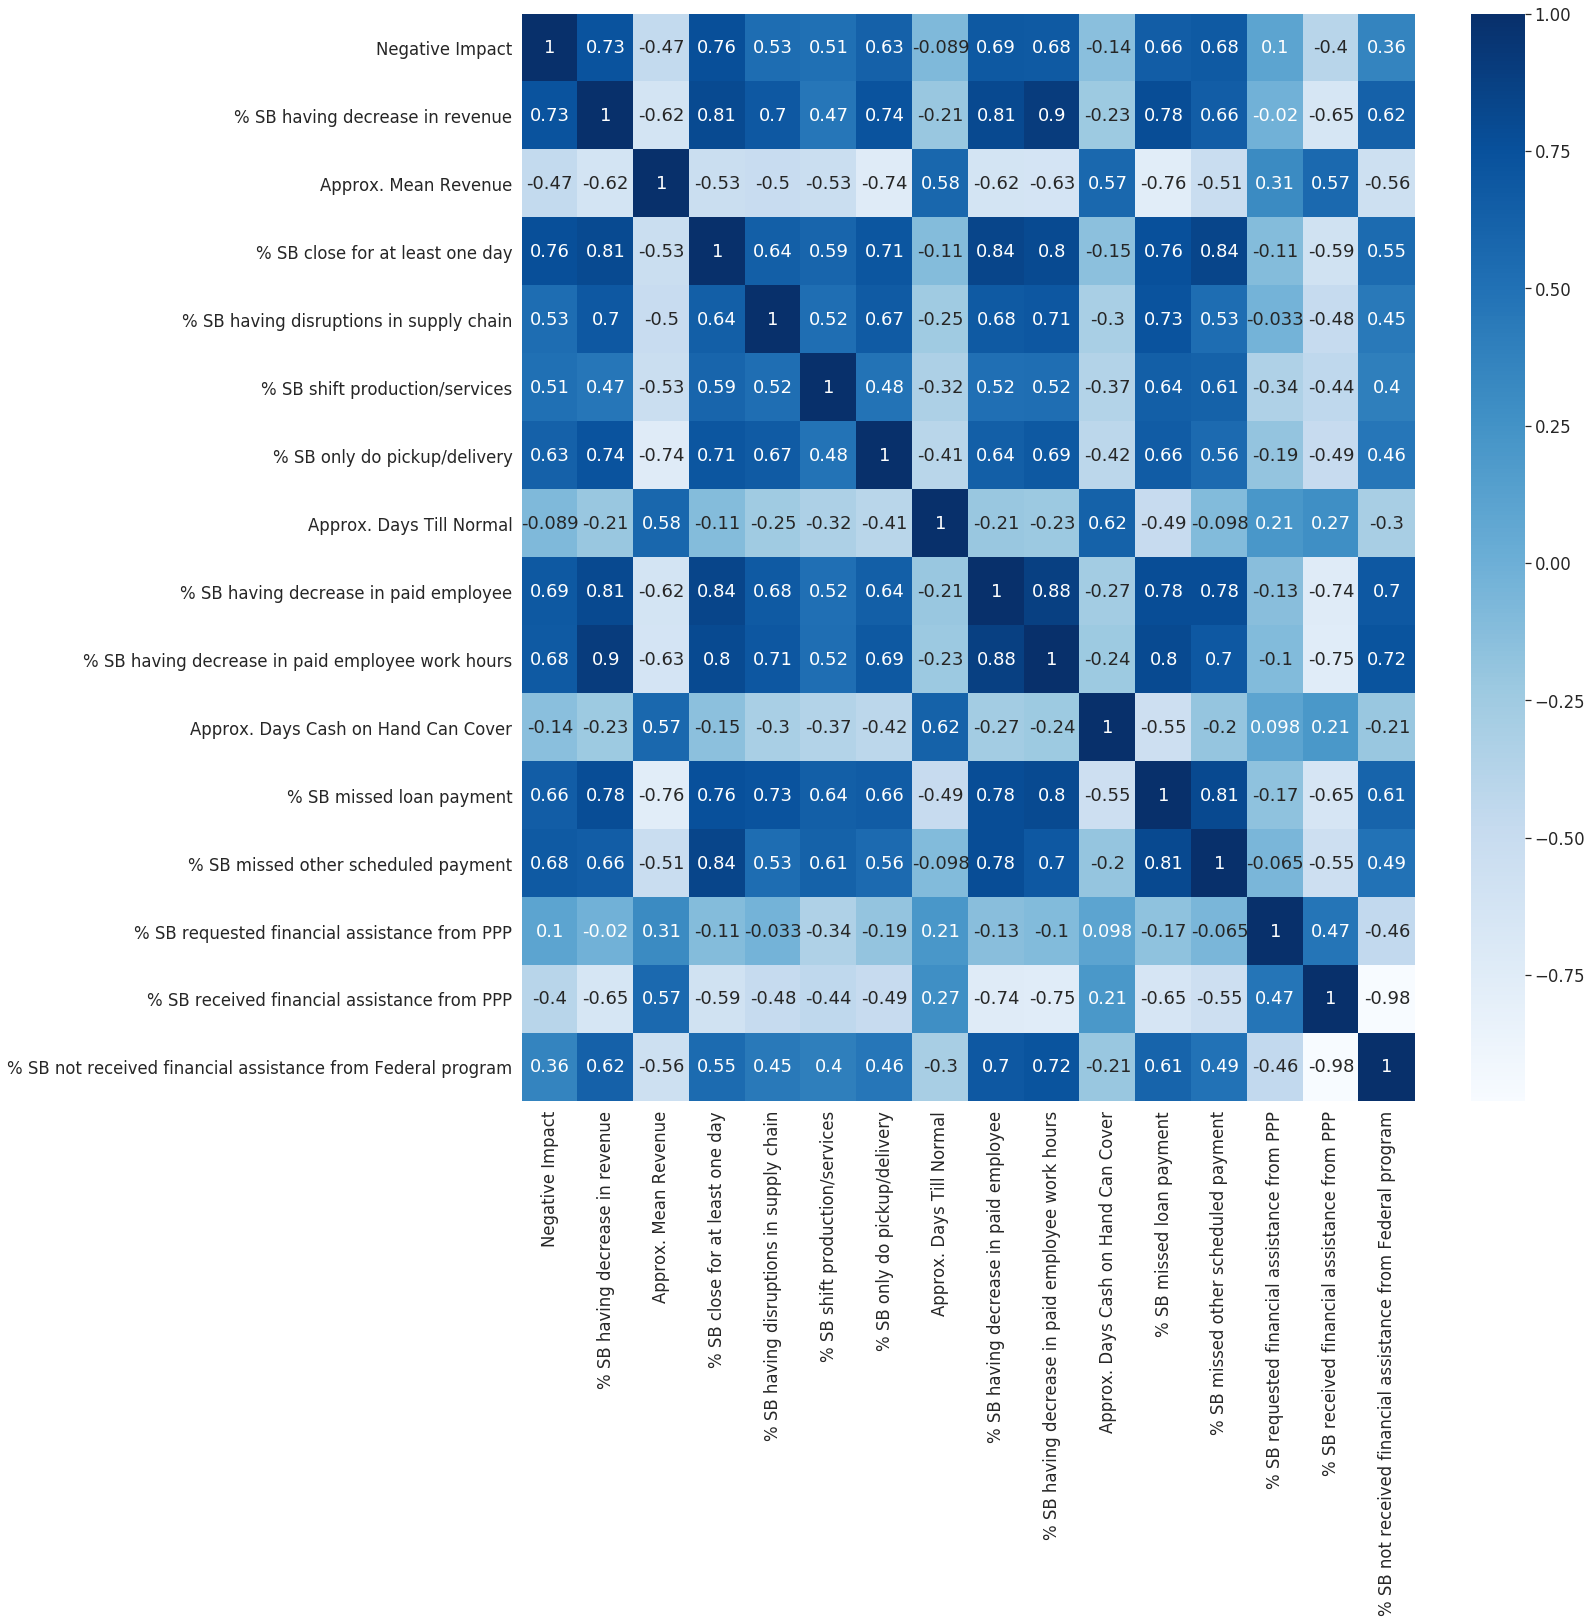

In [201]:
plt.figure(figsize=(20,20))
sns.heatmap(full_aggregate.corr(), annot=True, cmap="Blues");

Version of the aggregate table to join with policy table.

In [202]:
#drop PR
w1 = w1.drop([39]).reset_index(drop=True)
w2 = w2.drop([39]).reset_index(drop=True)
w3 = w3.drop([39]).reset_index(drop=True)
w4 = w4.drop([39]).reset_index(drop=True)
w5 = w5.drop([39]).reset_index(drop=True)
w6 = w6.drop([39]).reset_index(drop=True)

In [203]:
#% here means % of small business that experienced sth
aggregate = pd.concat([w1,w2,w3,w4,w5,w6]).set_index(['Full Name', 'Date'])
aggregate
#aggregate.to_csv('Small Business Pulse Survey.csv')

,,State,Negative Impact,% SB having decrease in revenue,Approx. Mean Revenue,% SB close for at least one day,% SB having disruptions in supply chain,% SB shift production/services,% SB only do pickup/delivery,Approx. Days Till Normal,% SB having decrease in paid employee,% SB having decrease in paid employee work hours,Approx. Days Cash on Hand Can Cover,% SB missed loan payment,% SB missed other scheduled payment,% SB requested financial assistance from PPP,% SB received financial assistance from PPP,% SB not received financial assistance from Federal program
Full Name,Date,,,,,,,,,,,,,,,,,
Alaska,2020-05-02,AK,89.4,0.655,4188.25,0.433,0.418,0.106,0.119,120.810,0.293,0.459,34.2205,NaN,0.214,0.691,0.422,0.538
Alabama,2020-05-02,AL,82.5,0.695,29899.75,0.334,0.516,0.077,0.134,172.440,0.169,0.453,46.5845,0.106,0.171,0.760,0.555,0.372
Arkansas,2020-05-02,AR,88.4,0.770,12858.75,0.263,0.479,0.059,0.142,159.195,0.199,0.428,50.7230,0.077,0.169,0.790,0.641,0.332
Arizona,2020-05-02,AZ,88.7,0.716,17271.00,0.310,0.417,0.067,0.153,240.570,0.268,0.505,66.3725,0.099,0.204,0.713,0.281,0.614
California,2020-05-02,CA,89.5,0.762,36245.75,0.478,0.464,0.077,0.146,246.285,0.315,0.532,62.6350,0.136,0.281,0.754,0.215,0.669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vermont,2020-06-06,VT,89.1,0.485,44311.00,0.337,0.409,NaN,0.132,195.675,0.196,0.326,61.6285,NaN,0.104,0.632,0.621,0.297
Washington,2020-06-06,WA,83.3,0.556,98879.25,0.294,0.325,0.059,0.101,270.465,0.153,0.296,97.9365,0.063,0.156,0.707,0.650,0.285
Wisconsin,2020-06-06,WI,79.0,0.446,105983.75,0.188,0.388,0.040,0.090,246.315,0.132,0.249,63.4015,0.041,0.121,0.772,0.759,0.203


In [204]:
aggregate.loc['California',:]

,State,Negative Impact,% SB having decrease in revenue,Approx. Mean Revenue,% SB close for at least one day,% SB having disruptions in supply chain,% SB shift production/services,% SB only do pickup/delivery,Approx. Days Till Normal,% SB having decrease in paid employee,% SB having decrease in paid employee work hours,Approx. Days Cash on Hand Can Cover,% SB missed loan payment,% SB missed other scheduled payment,% SB requested financial assistance from PPP,% SB received financial assistance from PPP,% SB not received financial assistance from Federal program
Date,,,,,,,,,,,,,,,,,
2020-05-02,CA,89.5,0.762,36245.75,0.478,0.464,0.077,0.146,246.285,0.315,0.532,62.6350,0.136,0.281,0.754,0.215,0.669
2020-05-09,CA,88.0,0.713,38471.25,0.442,0.435,0.065,0.141,245.745,0.273,0.489,65.9685,0.119,0.249,0.741,0.445,0.449
2020-05-16,CA,85.9,0.654,35576.75,0.409,0.419,0.075,0.144,260.280,0.242,0.406,74.0710,0.111,0.242,0.728,0.617,0.327
2020-05-23,CA,86.5,0.622,101414.25,0.394,0.405,0.081,0.127,289.035,0.203,0.360,91.7845,0.079,0.222,0.750,0.671,0.280
2020-05-30,CA,83.1,0.573,99819.50,0.365,0.383,0.068,0.127,278.700,0.179,0.321,91.1800,0.065,0.188,0.738,0.681,0.268
2020-06-06,CA,84.9,0.530,107971.25,0.364,0.366,0.068,0.116,281.730,0.167,0.305,88.6925,0.072,0.190,0.725,0.685,0.264
